In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-2
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [10]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-2
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [11]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [12]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [13]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [14]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
sobel_filter = Sobel().to(device)

In [17]:
def train_a2b_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_, tissue_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)
        tissue_y = tissue_y.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        _min = -500
        _max = 500
        tissue_window = (-128, 127)
        upper = ((tissue_window[1]) - (_min))/(_max-(_min))
        lower = ((tissue_window[0]) - (_min))/(_max-(_min))
        tissue_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        y_tissue_cls = tf_discriminator(tissue_y.float())
        y_pr_tissue_cls = tf_discriminator(tissue_pr.float().detach())

        tf_dis = 0
        for _y_cls, _y_pr_cls, _y_tissue_cls, _y_pr_tissue_cls in \
            zip(y_cls, y_pr_cls, y_tissue_cls, y_pr_tissue_cls):
            B, C = _y_cls.size()
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                            nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(B, dtype=torch.long, device=device)) + \
                            nn.CrossEntropyLoss()(_y_tissue_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                            nn.CrossEntropyLoss()(_y_pr_tissue_cls.float(), torch.ones(B, dtype=torch.long, device=device)) + \
                            tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(epoch + index / iteration)
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        edge_d_optim.zero_grad()        
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        edge_tissue_pr = sobel_filter(tissue_pr.float())
        edge_tissue_y = sobel_filter(tissue_y.float())
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        edge_tissue_y_cls = edge_discriminator(edge_tissue_y.float())
        edge_tissue_pr_cls = edge_discriminator(edge_tissue_pr.float().detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls, _edge_tissue_y_cls, _edge_tissue_pr_cls in \
            zip(edge_y_cls, edge_pr_cls, edge_tissue_y_cls, edge_tissue_pr_cls):
            B, C = _edge_y_cls.size()
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones(B, dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_tissue_y_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_tissue_pr_cls.float(), torch.ones(B, dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(epoch + index / iteration)

        edge_dis_l += edge_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        assert y_pr.requires_grad, "ct_pred without gradient"
        
        gen_optim.zero_grad()
        
        # soft tissue
        _min = -500
        _max = 500
        tissue_window = (-128, 127)
        upper = ((tissue_window[1]) - (_min))/(_max-(_min))
        lower = ((tissue_window[0]) - (_min))/(_max-(_min))
        tissue_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        assert tissue_pr.requires_grad, "tissue without gradient"
        
        # adversarial loss
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_tissue_cls = tf_discriminator(tissue_pr.float())
        
        tf_gen = 0
        for _y_pr_cls, _y_pr_tissue_cls in zip(y_pr_cls, y_pr_tissue_cls):
            B, C = _y_pr_cls.size()
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                            nn.CrossEntropyLoss()(_y_pr_tissue_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                            tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        

        edge_y_pr = sobel_filter(y_pr)
        edge_tissue_pr = sobel_filter(tissue_pr.float())
        
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        edge_tissue_pr_cls = edge_discriminator(edge_tissue_pr.float())
        
        edge_gen = 0
        for _edge_pr_cls, _edge_tissue_pr_cls in zip(edge_pr_cls, edge_tissue_pr_cls):
            B, C = _edge_pr_cls.size()
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) +\
                                    nn.CrossEntropyLoss()(_edge_tissue_pr_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) +\
                                    edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), \
                    edge_gen_l/(index+1), tf_gen_l/(index+1), \
                    edge_dis_l/(index+1), tf_dis_l/(index+1), \
                    tf_scheduler.get_last_lr()[0], edge_scheduler.get_last_lr()[0]

In [18]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_, tissue_y = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)
        tissue_y = tissue_y.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        # soft tissue
        _min = -500
        _max = 500
        tissue_window = (-128, 127)
        upper = ((tissue_window[1]) - (_min))/(_max-(_min))
        lower = ((tissue_window[0]) - (_min))/(_max-(_min))
        tissue_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            B, C = _y_cls.size()
            total = B
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            B, C = _y_pr_cls.size()
            total = B
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]

            
        y_tissue_cls = tf_discriminator(tissue_y.float())
        for _y_tissue_cls in y_tissue_cls:
            B, C = _y_tissue_cls.size()
            total = B
            _y_tissue_cls = Activation(name=DIS_ACT)(_y_tissue_cls)
            _, _y_tissue_cls = torch.max(_y_tissue_cls.data, 1)
            correct = (_y_tissue_cls == torch.zeros(B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]   
            
        y_pr_tissue_cls = tf_discriminator(tissue_pr.float())
        for _y_pr_tissue_cls in y_pr_tissue_cls:
            B, C = _y_pr_tissue_cls.size()
            total = B
            _y_pr_tissue_cls = Activation(name=DIS_ACT)(_y_pr_tissue_cls)
            _, _y_pr_tissue_cls = torch.max(_y_pr_tissue_cls.data, 1)
            correct = (_y_pr_tissue_cls == torch.zeros(B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]           
        
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  

        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        edge_tissue_pr = sobel_filter(tissue_pr)
        edge_tissue_y = sobel_filter(tissue_y)
        
        edge_y_cls = edge_discriminator(edge_y)
        for _edge_y_cls in edge_y_cls:
            B, C = _edge_y_cls.size()
            total = B
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros((B), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            B, C = _edge_pr_cls.size()
            total = B
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones((B), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        

        edge_tissue_y_cls = edge_discriminator(edge_tissue_y.float())
        for _edge_tissue_y_cls in edge_tissue_y_cls:
            B, C = _edge_tissue_y_cls.size()
            total = B
            _edge_tissue_y_cls = Activation(name=DIS_ACT)(_edge_tissue_y_cls)
            _, _edge_tissue_y_cls = torch.max(_edge_tissue_y_cls.data, 1)
            correct = (_edge_tissue_y_cls == torch.zeros((B), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_tissue_pr_cls = edge_discriminator(edge_tissue_pr.float())
        for _edge_tissue_pr_cls in edge_tissue_pr_cls:
            B, C = _edge_tissue_pr_cls.size()
            total = B
            _edge_tissue_pr_cls = Activation(name=DIS_ACT)(_edge_tissue_pr_cls)
            _, _edge_tissue_pr_cls = torch.max(_edge_tissue_pr_cls.data, 1)
            correct = (_edge_tissue_pr_cls == torch.zeros((B), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]     
            
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [19]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [20]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(512, ), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc([x[-1]])
        return x

# Generator

In [22]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [23]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [24]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [25]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [26]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [27]:
len(trainset), len(testset)

(1344, 191)

In [28]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f8ad9fedd90>,)

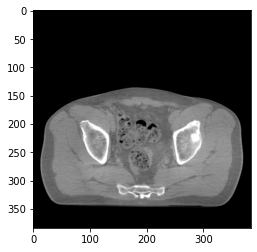

In [29]:
plt.imshow(x.squeeze(), 'gray'),

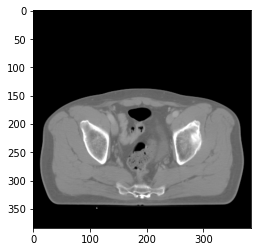

In [30]:
plt.imshow(y.squeeze(), 'gray')

In [31]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [34]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [35]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [36]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [38]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=10, T_mult=2, eta_min=3e-4)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=10, T_mult=2, eta_min=3e-4)

In [39]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [40]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis, tf_lr, edge_lr = train_a2b_epoch(epoch, model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "lr scheduler tf": tf_lr,
            "lr scheduler edge": edge_lr,
            
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_snr_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_snr_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [02:06,  1.33it/s]
168it [02:59,  1.07s/it]
168it [01:24,  2.00it/s]
24it [00:12,  1.90it/s]
168it [02:07,  1.32it/s]
168it [02:58,  1.06s/it]
168it [01:21,  2.07it/s]
24it [00:13,  1.81it/s]
168it [02:11,  1.28it/s]
168it [02:52,  1.02s/it]
168it [01:27,  1.93it/s]
24it [00:12,  1.95it/s]
168it [02:10,  1.29it/s]
168it [02:53,  1.03s/it]
168it [01:24,  1.99it/s]
24it [00:12,  1.94it/s]
168it [02:05,  1.34it/s]
168it [02:58,  1.06s/it]
168it [01:23,  2.01it/s]
24it [00:12,  1.92it/s]
168it [02:08,  1.31it/s]
168it [03:00,  1.08s/it]
168it [01:20,  2.09it/s]
24it [00:13,  1.79it/s]
168it [02:11,  1.27it/s]
168it [02:52,  1.02s/it]
168it [01:27,  1.92it/s]
24it [00:12,  1.94it/s]
168it [02:10,  1.28it/s]
168it [02:52,  1.03s/it]
168it [01:24,  1.99it/s]
24it [00:12,  1.93it/s]
168it [02:06,  1.33it/s]
168it [02:57,  1.06s/it]
168it [01:23,  2.01it/s]
24it [00:11,  2.07it/s]
168it [02:08,  1.31it/s]
168it [02:59,  1.07s/it]
168it [01:19,  2.12it/s]
24it [00:13,  1.77it/s]
168it [02:

In [41]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [42]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [43]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8169271945953369
psnr score = 22.61075210571289
snr score = 12.673690795898438
mae error = 0.029482509940862656
air dice score = 0.9705730708270757
bone dice score = 0.8407626561493654
contour dice score = 0.003535651136189699


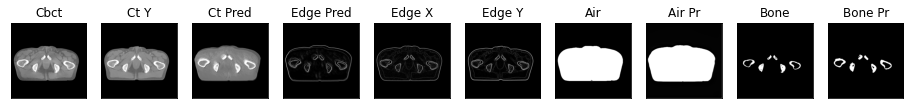

1it [00:00,  1.86it/s]

ssim score = 0.8190248012542725
psnr score = 22.634946823120117
snr score = 12.74542236328125
mae error = 0.02954496629536152
air dice score = 0.9710304013745324
bone dice score = 0.8224201152459086
contour dice score = 0.011813349090516567


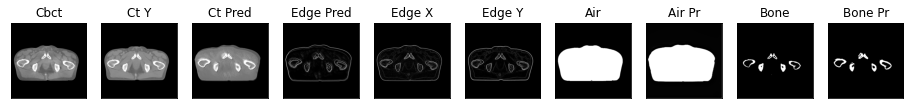

2it [00:00,  2.05it/s]

ssim score = 0.8211243152618408
psnr score = 22.727554321289062
snr score = 13.000923156738281
mae error = 0.029343439266085625
air dice score = 0.9717201054763904
bone dice score = 0.8496686431827732
contour dice score = 0.009461856447160244


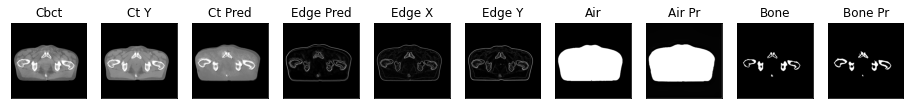

3it [00:01,  2.21it/s]

ssim score = 0.8152469396591187
psnr score = 22.537490844726562
snr score = 12.900114059448242
mae error = 0.030346227809786797
air dice score = 0.9712283254981462
bone dice score = 0.8181426416740126
contour dice score = 0.0071132187731564045


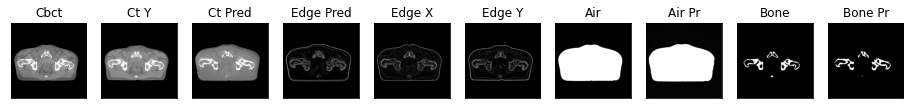

4it [00:01,  2.34it/s]

ssim score = 0.8126453161239624
psnr score = 22.4074649810791
snr score = 12.81038761138916
mae error = 0.031159570440649986
air dice score = 0.9714604193492865
bone dice score = 0.7759311173430523
contour dice score = 0.015430266968905926


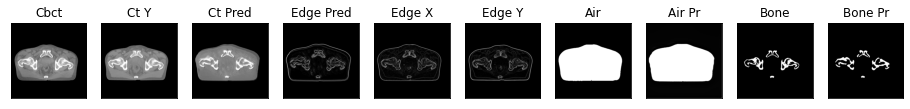

5it [00:02,  2.43it/s]

ssim score = 0.8115862011909485
psnr score = 22.260398864746094
snr score = 12.799858093261719
mae error = 0.0320076085627079
air dice score = 0.97171432432957
bone dice score = 0.7549909255920599
contour dice score = 0.02142857201397419


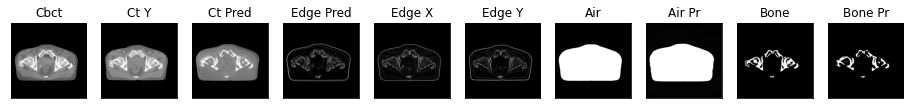

6it [00:02,  2.51it/s]

ssim score = 0.8098467588424683
psnr score = 22.3176212310791
snr score = 12.833023071289062
mae error = 0.031654782593250275
air dice score = 0.9700943826328485
bone dice score = 0.7577454927379857
contour dice score = 0.015513126738369465


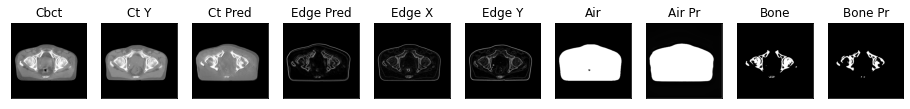

7it [00:02,  2.56it/s]

ssim score = 0.8155352473258972
psnr score = 22.679414749145508
snr score = 13.00928020477295
mae error = 0.029813697561621666
air dice score = 0.969294783718762
bone dice score = 0.7982602258023481
contour dice score = 0.009580838494002819


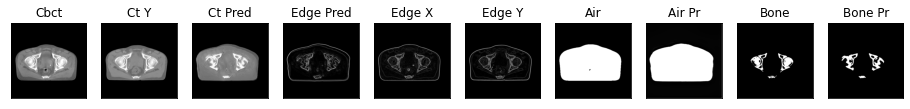

8it [00:03,  2.20it/s]

ssim score = 0.8185564279556274
psnr score = 22.844451904296875
snr score = 13.07976245880127
mae error = 0.028863323852419853
air dice score = 0.9693518509443694
bone dice score = 0.8104168691107724
contour dice score = 0.008403361774981022


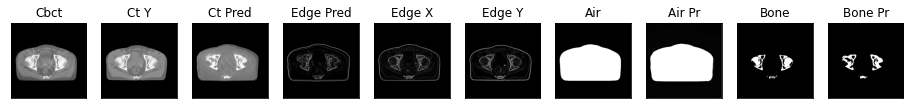

9it [00:03,  2.29it/s]

ssim score = 0.8214132189750671
psnr score = 22.916297912597656
snr score = 13.136323928833008
mae error = 0.028525475412607193
air dice score = 0.967911594374219
bone dice score = 0.7940936863564756
contour dice score = 0.00481637567281723


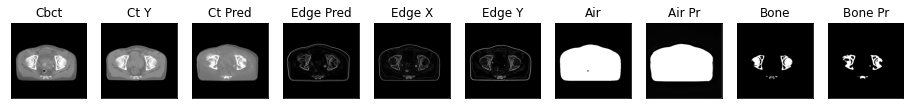

10it [00:04,  2.34it/s]

ssim score = 0.829055905342102
psnr score = 23.111448287963867
snr score = 13.363743782043457
mae error = 0.027426784858107567
air dice score = 0.9633696745066702
bone dice score = 0.8541252744969765
contour dice score = 0.0036166366189718246


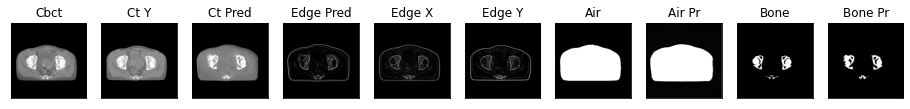

11it [00:04,  2.43it/s]

ssim score = 0.8302502036094666
psnr score = 22.981765747070312
snr score = 13.257771492004395
mae error = 0.028038598597049713
air dice score = 0.9577685295283811
bone dice score = 0.8841094174161191
contour dice score = 0.006035002879798412


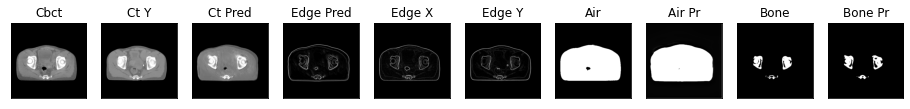

12it [00:04,  2.48it/s]

ssim score = 0.834077775478363
psnr score = 22.749778747558594
snr score = 12.993864059448242
mae error = 0.02826862223446369
air dice score = 0.9550455140439502
bone dice score = 0.887783305694994
contour dice score = 0.007246376946568489


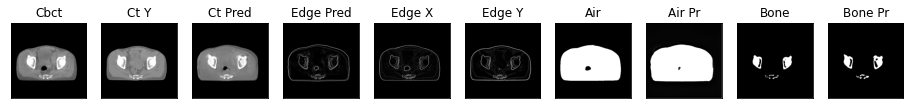

13it [00:05,  1.82it/s]

ssim score = 0.8301740884780884
psnr score = 22.467021942138672
snr score = 12.569150924682617
mae error = 0.029257161542773247
air dice score = 0.954045893719853
bone dice score = 0.8430851063848755
contour dice score = 0.0012165450025349855


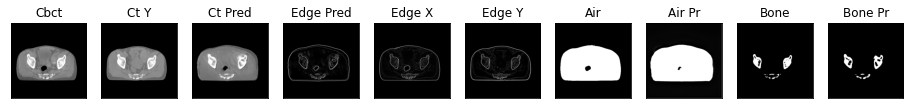

14it [00:06,  1.73it/s]

ssim score = 0.8298532366752625
psnr score = 22.556142807006836
snr score = 12.572608947753906
mae error = 0.029351690784096718
air dice score = 0.9534608498629887
bone dice score = 0.8262922465230331
contour dice score = 0.015795867890119553


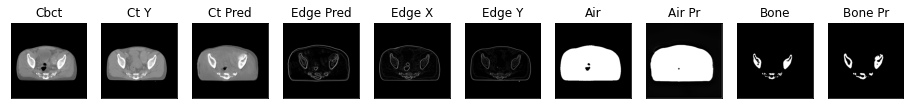

15it [00:07,  1.75it/s]

ssim score = 0.8271538019180298
psnr score = 22.098392486572266
snr score = 12.138345718383789
mae error = 0.030865544453263283
air dice score = 0.9533437172322294
bone dice score = 0.8294582792419513
contour dice score = 6.165228050303284e-11


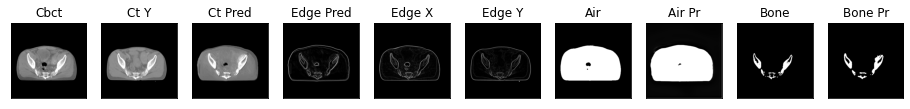

16it [00:07,  1.84it/s]

ssim score = 0.8219310641288757
psnr score = 21.659793853759766
snr score = 11.697202682495117
mae error = 0.03207986429333687
air dice score = 0.9502206712512058
bone dice score = 0.8113765642797339
contour dice score = 6.195786939056092e-11


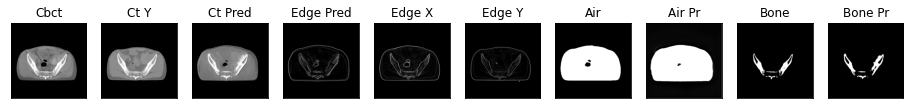

17it [00:08,  1.88it/s]

ssim score = 0.8157824277877808
psnr score = 21.369937896728516
snr score = 11.305584907531738
mae error = 0.03338642418384552
air dice score = 0.9457844381831689
bone dice score = 0.7527700831053465
contour dice score = 0.017104459926486015


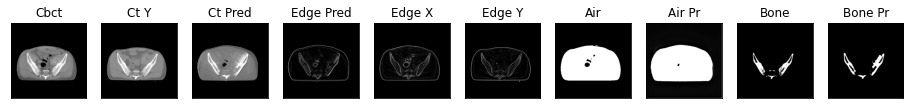

18it [00:08,  1.62it/s]

ssim score = 0.8132631778717041
psnr score = 21.547658920288086
snr score = 11.432622909545898
mae error = 0.032935068011283875
air dice score = 0.9451572353180079
bone dice score = 0.7498051441960827
contour dice score = 0.01130653265863657


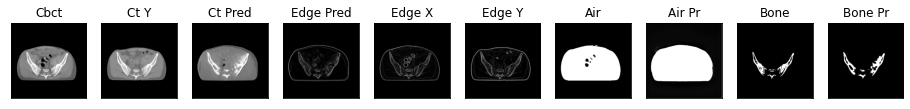

19it [00:09,  1.72it/s]

ssim score = 0.815671443939209
psnr score = 21.294336318969727
snr score = 11.1669921875
mae error = 0.03357449918985367
air dice score = 0.9470851830137081
bone dice score = 0.7886710239675647
contour dice score = 0.02369077317416668


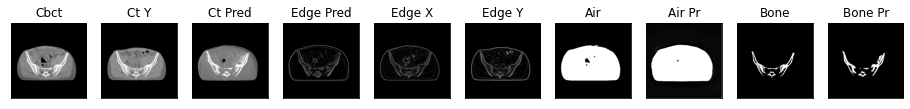

20it [00:09,  1.78it/s]

ssim score = 0.8124803304672241
psnr score = 20.986204147338867
snr score = 10.794012069702148
mae error = 0.03463948145508766
air dice score = 0.9471682565842158
bone dice score = 0.7878341918103037
contour dice score = 0.011342154815793037


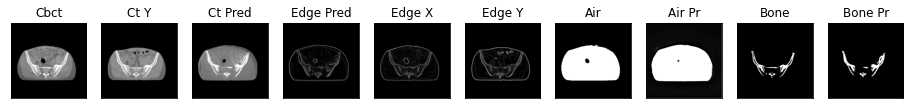

21it [00:10,  1.79it/s]

ssim score = 0.8111000061035156
psnr score = 21.006574630737305
snr score = 10.754953384399414
mae error = 0.03425249829888344
air dice score = 0.9478353366663675
bone dice score = 0.8191646191668407
contour dice score = 0.007614213041961193


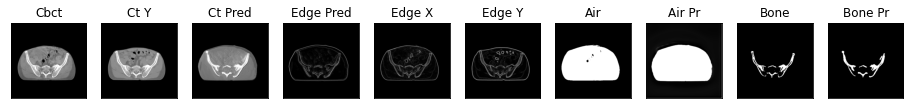

22it [00:10,  1.88it/s]

ssim score = 0.8138269782066345
psnr score = 20.84907341003418
snr score = 10.564023971557617
mae error = 0.034613292664289474
air dice score = 0.9471941517953696
bone dice score = 0.8288331152631279
contour dice score = 0.015315890312194824


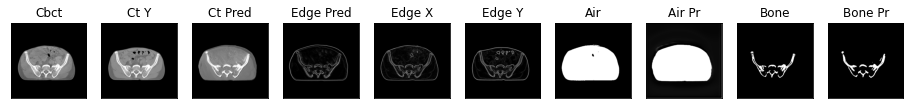

23it [00:11,  1.91it/s]

ssim score = 0.8148579597473145
psnr score = 20.71346092224121
snr score = 10.379847526550293
mae error = 0.03513133525848389
air dice score = 0.9468215490407197
bone dice score = 0.814692724278141
contour dice score = 0.011703510768711567


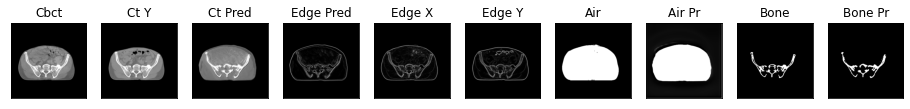

24it [00:11,  1.92it/s]

ssim score = 0.815790057182312
psnr score = 20.727407455444336
snr score = 10.296793937683105
mae error = 0.03495325520634651
air dice score = 0.9465721040189713
bone dice score = 0.8052215733447243
contour dice score = 0.025049440562725067


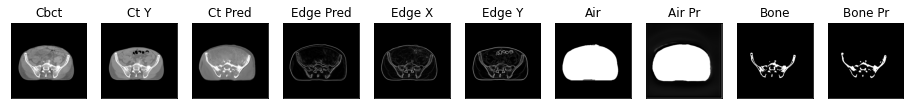

25it [00:12,  1.95it/s]

ssim score = 0.8202379941940308
psnr score = 20.868125915527344
snr score = 10.354776382446289
mae error = 0.034023355692625046
air dice score = 0.9444544189596207
bone dice score = 0.7813545632885501
contour dice score = 0.014686248265206814


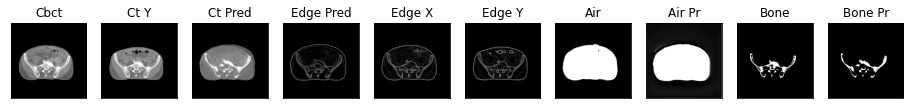

26it [00:12,  2.00it/s]

ssim score = 0.8208955526351929
psnr score = 20.857322692871094
snr score = 10.252789497375488
mae error = 0.03403137996792793
air dice score = 0.9356733117510811
bone dice score = 0.7570776255735493
contour dice score = 0.012311901897192001


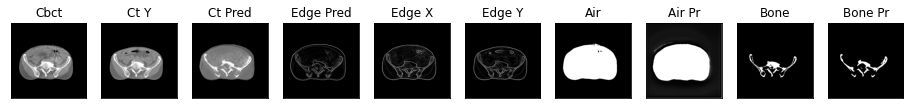

27it [00:13,  2.01it/s]

ssim score = 0.819729208946228
psnr score = 20.872907638549805
snr score = 10.227269172668457
mae error = 0.03365032747387886
air dice score = 0.9347638398048386
bone dice score = 0.7916756991134654
contour dice score = 0.011072664521634579


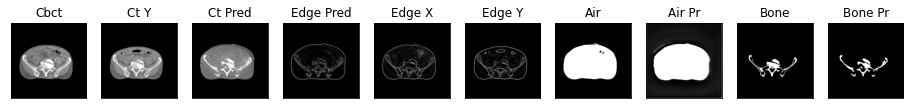

28it [00:14,  1.69it/s]

ssim score = 0.7894594669342041
psnr score = 22.27675437927246
snr score = 13.64891242980957
mae error = 0.0370241217315197
air dice score = 0.9877093199238468
bone dice score = 0.7947732513503774
contour dice score = 0.34711456298828125


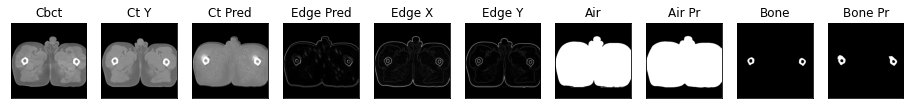

29it [00:14,  1.78it/s]

ssim score = 0.7926409840583801
psnr score = 22.65366554260254
snr score = 14.065082550048828
mae error = 0.03662683069705963
air dice score = 0.9894947049924421
bone dice score = 0.8123924268548711
contour dice score = 0.40305474400520325


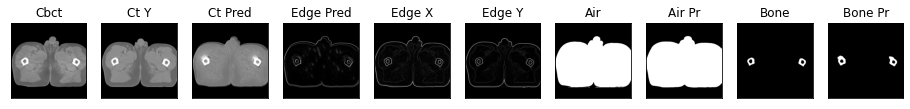

30it [00:15,  1.86it/s]

ssim score = 0.794907808303833
psnr score = 22.956687927246094
snr score = 14.455551147460938
mae error = 0.03641137853264809
air dice score = 0.9896083902626831
bone dice score = 0.8301657905412421
contour dice score = 0.3724444508552551


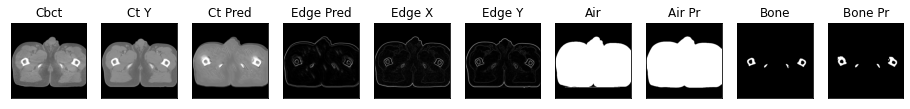

31it [00:15,  1.97it/s]

ssim score = 0.7927756905555725
psnr score = 23.079137802124023
snr score = 14.740560531616211
mae error = 0.03734545037150383
air dice score = 0.9904122378626888
bone dice score = 0.8586988519302517
contour dice score = 0.37013283371925354


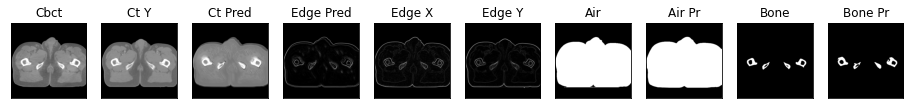

32it [00:16,  2.02it/s]

ssim score = 0.7948070168495178
psnr score = 23.28455924987793
snr score = 15.07412338256836
mae error = 0.03700672462582588
air dice score = 0.9914191497862292
bone dice score = 0.8347473724219989
contour dice score = 0.40110906958580017


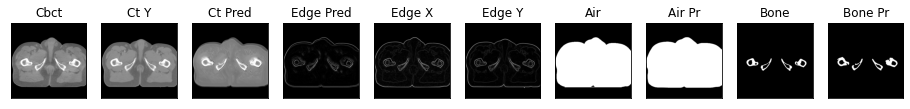

33it [00:16,  2.05it/s]

ssim score = 0.7970539331436157
psnr score = 23.513919830322266
snr score = 15.406721115112305
mae error = 0.03645448759198189
air dice score = 0.9913006274957268
bone dice score = 0.8293066636719933
contour dice score = 0.37187787890434265


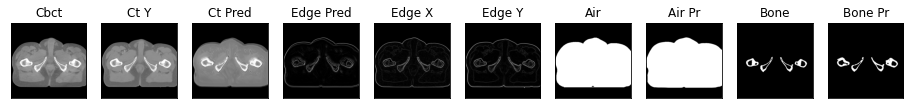

34it [00:16,  2.11it/s]

ssim score = 0.7928590178489685
psnr score = 23.547786712646484
snr score = 15.507692337036133
mae error = 0.036968812346458435
air dice score = 0.991613548528381
bone dice score = 0.8260322783501778
contour dice score = 0.40110906958580017


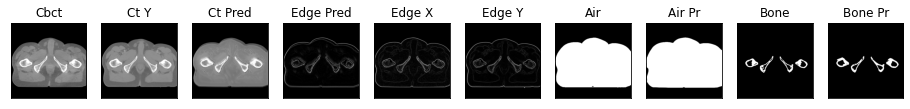

35it [00:17,  2.07it/s]

ssim score = 0.7850503921508789
psnr score = 23.472869873046875
snr score = 15.422882080078125
mae error = 0.03763283044099808
air dice score = 0.991350420088743
bone dice score = 0.8228476821210383
contour dice score = 0.3771323263645172


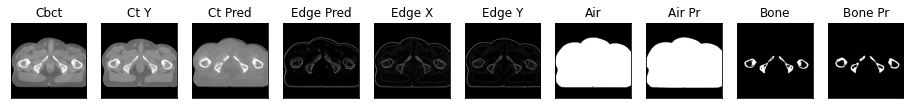

36it [00:17,  2.11it/s]

ssim score = 0.7888025641441345
psnr score = 23.615432739257812
snr score = 15.551780700683594
mae error = 0.03664460778236389
air dice score = 0.9916311831186702
bone dice score = 0.8291524723874352
contour dice score = 0.4000000059604645


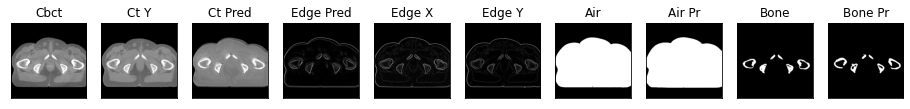

37it [00:18,  2.08it/s]

ssim score = 0.7948971390724182
psnr score = 23.733482360839844
snr score = 15.681833267211914
mae error = 0.03643389418721199
air dice score = 0.9917987456905222
bone dice score = 0.8114789337939436
contour dice score = 0.38543108105659485


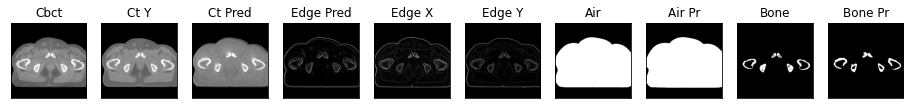

38it [00:19,  1.73it/s]

ssim score = 0.7936740517616272
psnr score = 23.74169158935547
snr score = 15.7291259765625
mae error = 0.03634220361709595
air dice score = 0.9918024110555768
bone dice score = 0.8314776780906769
contour dice score = 0.390018492937088


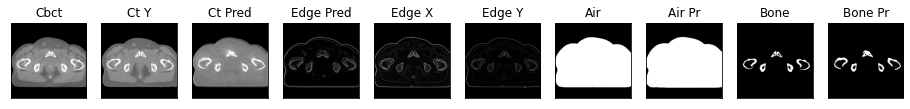

39it [00:19,  1.85it/s]

ssim score = 0.792413055896759
psnr score = 23.808650970458984
snr score = 15.93737506866455
mae error = 0.03643675521016121
air dice score = 0.9919578300848976
bone dice score = 0.8219151794298416
contour dice score = 0.3693735599517822


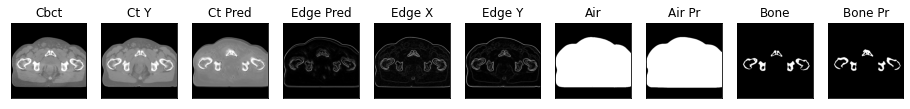

40it [00:20,  1.88it/s]

ssim score = 0.7955869436264038
psnr score = 23.83406639099121
snr score = 16.057476043701172
mae error = 0.036885373294353485
air dice score = 0.9922153536091693
bone dice score = 0.7935467607781401
contour dice score = 0.3817504644393921


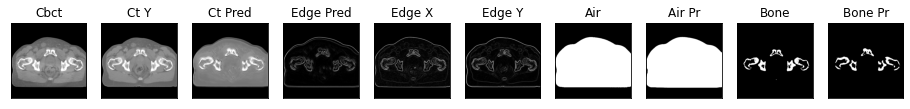

41it [00:20,  1.93it/s]

ssim score = 0.7881625294685364
psnr score = 23.6263370513916
snr score = 15.81570053100586
mae error = 0.03766562044620514
air dice score = 0.9924554183813488
bone dice score = 0.7430917957075619
contour dice score = 0.37890806794166565


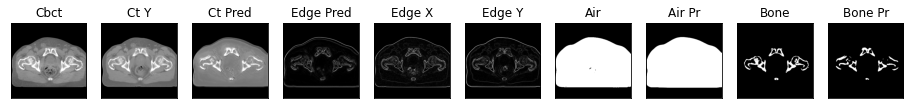

42it [00:21,  2.00it/s]

ssim score = 0.7823746800422668
psnr score = 23.17579460144043
snr score = 15.437345504760742
mae error = 0.039394866675138474
air dice score = 0.9912379187235333
bone dice score = 0.7006497524775631
contour dice score = 0.3900841772556305


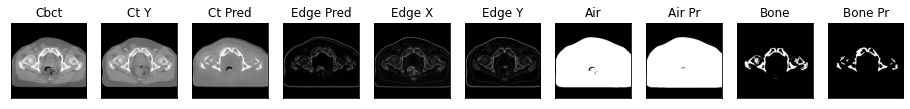

43it [00:21,  2.00it/s]

ssim score = 0.786763072013855
psnr score = 23.23002052307129
snr score = 15.355476379394531
mae error = 0.03844689205288887
air dice score = 0.9908877989475432
bone dice score = 0.7308049823412269
contour dice score = 0.3448922336101532


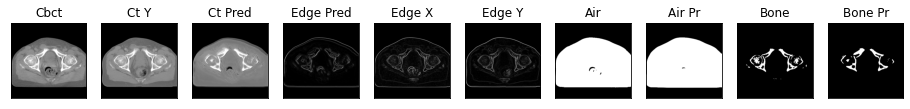

44it [00:22,  2.04it/s]

ssim score = 0.7976341247558594
psnr score = 23.144142150878906
snr score = 15.09103775024414
mae error = 0.03817154839634895
air dice score = 0.9909923910509728
bone dice score = 0.7030075187999306
contour dice score = 0.3576470613479614


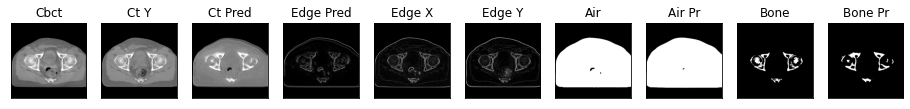

45it [00:22,  2.06it/s]

ssim score = 0.7932264804840088
psnr score = 23.053876876831055
snr score = 14.91018295288086
mae error = 0.03865117207169533
air dice score = 0.9916617747481211
bone dice score = 0.6988752008602155
contour dice score = 0.3431001901626587


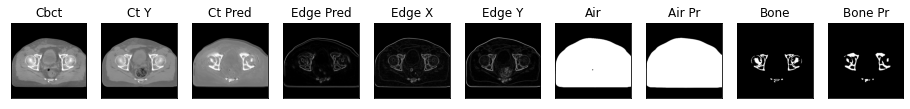

46it [00:23,  2.08it/s]

ssim score = 0.7957303524017334
psnr score = 22.87851333618164
snr score = 14.750509262084961
mae error = 0.0394931361079216
air dice score = 0.9914927923375018
bone dice score = 0.7191977077392632
contour dice score = 0.3473336398601532


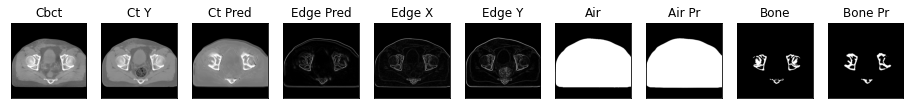

47it [00:23,  2.07it/s]

ssim score = 0.7902761101722717
psnr score = 22.895191192626953
snr score = 14.777222633361816
mae error = 0.03924931213259697
air dice score = 0.9913592414998329
bone dice score = 0.7009273570353465
contour dice score = 0.33931946754455566


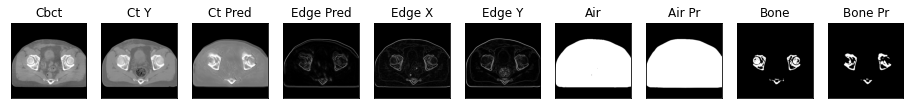

48it [00:24,  1.70it/s]

ssim score = 0.799188494682312
psnr score = 23.05133819580078
snr score = 14.994958877563477
mae error = 0.03855178505182266
air dice score = 0.991113079242221
bone dice score = 0.782902137234881
contour dice score = 0.3119092583656311


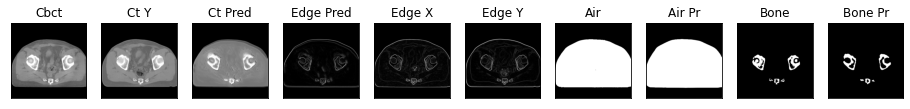

49it [00:24,  1.79it/s]

ssim score = 0.7967742085456848
psnr score = 23.64992904663086
snr score = 15.663629531860352
mae error = 0.03662586957216263
air dice score = 0.9910453205264652
bone dice score = 0.8453790422349763
contour dice score = 0.3197729289531708


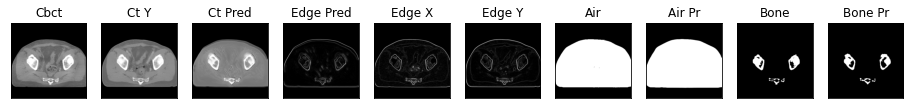

50it [00:25,  1.89it/s]

ssim score = 0.7953380942344666
psnr score = 23.130420684814453
snr score = 15.025018692016602
mae error = 0.03791269659996033
air dice score = 0.9910026019502522
bone dice score = 0.7816280500329953
contour dice score = 0.3196605443954468


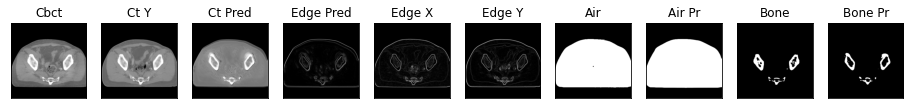

51it [00:25,  1.94it/s]

ssim score = 0.7893514633178711
psnr score = 22.771480560302734
snr score = 14.747703552246094
mae error = 0.039652109146118164
air dice score = 0.9905755474319639
bone dice score = 0.8188962153390037
contour dice score = 0.294536828994751


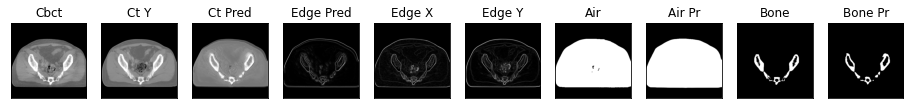

52it [00:26,  2.01it/s]

ssim score = 0.7892897725105286
psnr score = 23.085140228271484
snr score = 15.141511917114258
mae error = 0.03915054351091385
air dice score = 0.9901973851615855
bone dice score = 0.8005319148951773
contour dice score = 0.30372491478919983


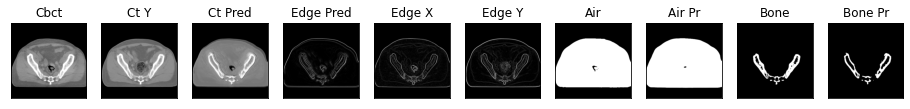

53it [00:26,  2.07it/s]

ssim score = 0.781807541847229
psnr score = 22.813152313232422
snr score = 14.891080856323242
mae error = 0.04029758647084236
air dice score = 0.9903260133501074
bone dice score = 0.7959725257586951
contour dice score = 0.2777777910232544


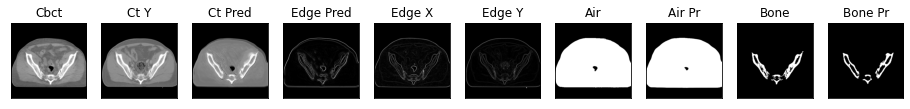

54it [00:27,  2.03it/s]

ssim score = 0.7828167676925659
psnr score = 23.043336868286133
snr score = 15.13380241394043
mae error = 0.04022400453686714
air dice score = 0.9915957306311657
bone dice score = 0.801195344449503
contour dice score = 0.30975142121315


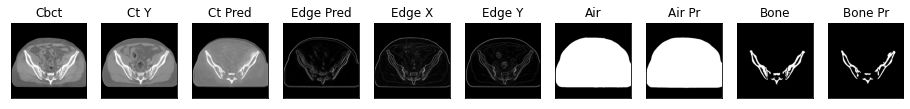

55it [00:27,  2.03it/s]

ssim score = 0.7954230308532715
psnr score = 20.566633224487305
snr score = 10.446839332580566
mae error = 0.036242563277482986
air dice score = 0.9730307215259374
bone dice score = 0.7921706619794993
contour dice score = 0.0219058059155941


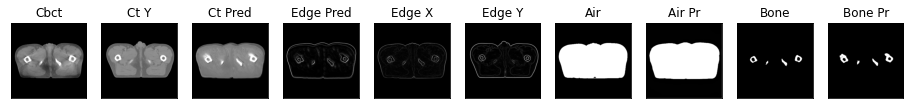

56it [00:28,  2.07it/s]

ssim score = 0.7857965230941772
psnr score = 20.309221267700195
snr score = 10.402410507202148
mae error = 0.03809668496251106
air dice score = 0.9743186220254788
bone dice score = 0.7619542619583861
contour dice score = 0.03814714029431343


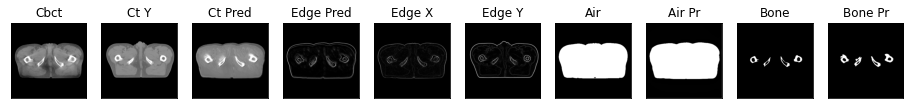

57it [00:28,  2.06it/s]

ssim score = 0.7762420773506165
psnr score = 20.16997528076172
snr score = 10.394304275512695
mae error = 0.03934354707598686
air dice score = 0.9750890905021992
bone dice score = 0.7452996946851149
contour dice score = 0.04021739214658737


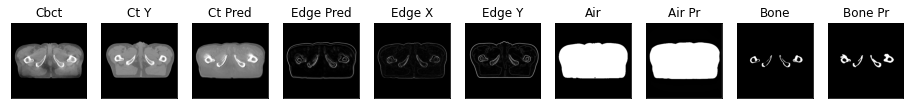

58it [00:29,  1.71it/s]

ssim score = 0.7742295265197754
psnr score = 20.44063949584961
snr score = 10.735369682312012
mae error = 0.03815620020031929
air dice score = 0.9761694616063752
bone dice score = 0.7469203181077979
contour dice score = 0.04983748495578766


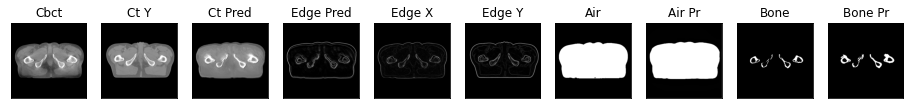

59it [00:29,  1.80it/s]

ssim score = 0.7758923768997192
psnr score = 20.580472946166992
snr score = 10.922769546508789
mae error = 0.037526875734329224
air dice score = 0.976466869965596
bone dice score = 0.7495682210747437
contour dice score = 0.06260118633508682


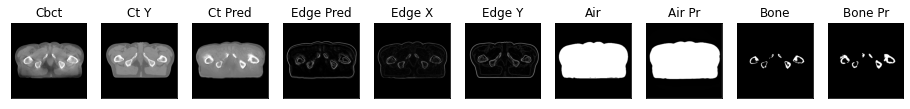

60it [00:30,  1.88it/s]

ssim score = 0.7776857614517212
psnr score = 20.79948616027832
snr score = 11.147397994995117
mae error = 0.036786772310733795
air dice score = 0.9771590686420873
bone dice score = 0.7554517133994478
contour dice score = 0.07469752430915833


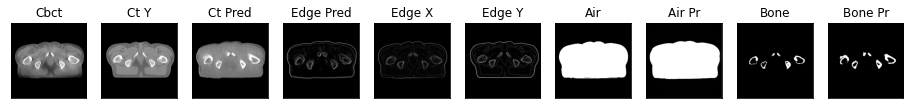

61it [00:30,  1.93it/s]

ssim score = 0.782982587814331
psnr score = 20.865995407104492
snr score = 11.207405090332031
mae error = 0.03637426346540451
air dice score = 0.9776501669229456
bone dice score = 0.760611205436632
contour dice score = 0.07907222211360931


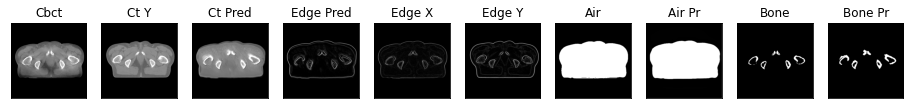

62it [00:31,  1.97it/s]

ssim score = 0.7874850034713745
psnr score = 20.78606414794922
snr score = 11.141584396362305
mae error = 0.03635890781879425
air dice score = 0.9781237031328261
bone dice score = 0.7629051620683838
contour dice score = 0.08846761286258698


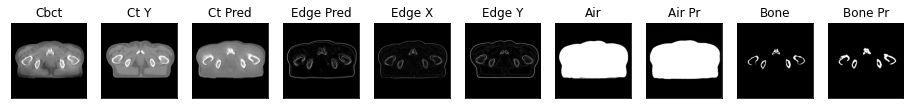

63it [00:31,  2.03it/s]

ssim score = 0.7865046262741089
psnr score = 20.833322525024414
snr score = 11.246849060058594
mae error = 0.0361388735473156
air dice score = 0.9774822785024467
bone dice score = 0.7768458682830077
contour dice score = 0.10687831044197083


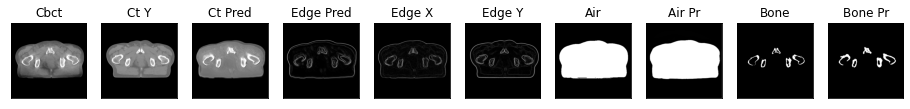

64it [00:32,  2.04it/s]

ssim score = 0.7809061408042908
psnr score = 20.712726593017578
snr score = 11.224811553955078
mae error = 0.037084486335515976
air dice score = 0.9780774293718753
bone dice score = 0.7483119290381529
contour dice score = 0.0774463638663292


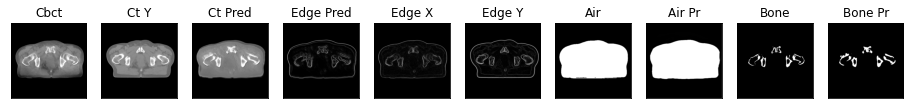

65it [00:32,  2.07it/s]

ssim score = 0.7702136635780334
psnr score = 20.502965927124023
snr score = 11.050880432128906
mae error = 0.038616843521595
air dice score = 0.9783658505752152
bone dice score = 0.7454497494098463
contour dice score = 0.0980287715792656


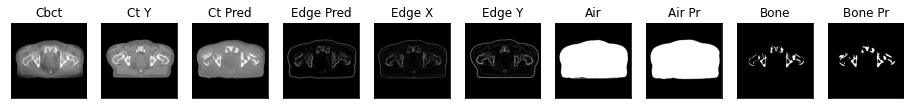

66it [00:33,  2.05it/s]

ssim score = 0.7553619742393494
psnr score = 20.097482681274414
snr score = 10.678101539611816
mae error = 0.04050952568650246
air dice score = 0.9782550109483087
bone dice score = 0.7329855347435026
contour dice score = 0.060445386916399


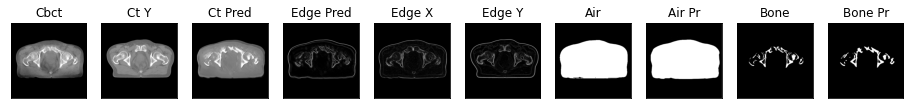

67it [00:33,  2.05it/s]

ssim score = 0.761297345161438
psnr score = 20.31403350830078
snr score = 11.011470794677734
mae error = 0.0399211049079895
air dice score = 0.9774681542060196
bone dice score = 0.7106575437816228
contour dice score = 0.03237598016858101


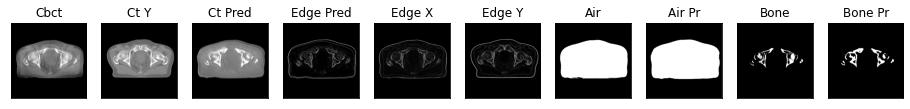

68it [00:34,  1.75it/s]

ssim score = 0.767493486404419
psnr score = 20.462533950805664
snr score = 11.1439847946167
mae error = 0.038891423493623734
air dice score = 0.9774420912745997
bone dice score = 0.7258064516163051
contour dice score = 0.04851752147078514


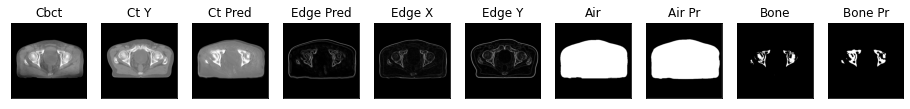

69it [00:35,  1.83it/s]

ssim score = 0.7742685079574585
psnr score = 20.89401626586914
snr score = 11.37630558013916
mae error = 0.036412835121154785
air dice score = 0.9760981586854188
bone dice score = 0.7504098877569629
contour dice score = 0.02444208227097988


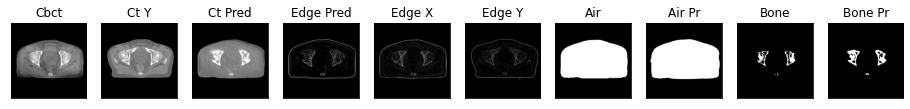

70it [00:35,  1.86it/s]

ssim score = 0.7902051210403442
psnr score = 21.503986358642578
snr score = 11.81588363647461
mae error = 0.033851828426122665
air dice score = 0.9758352947089131
bone dice score = 0.7982916412471226
contour dice score = 0.03407880663871765


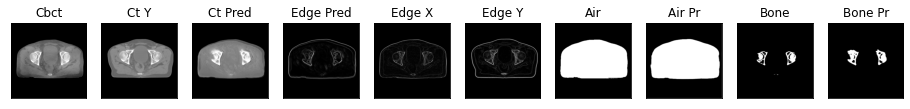

71it [00:36,  1.90it/s]

ssim score = 0.7889595031738281
psnr score = 21.710100173950195
snr score = 12.036163330078125
mae error = 0.03346725180745125
air dice score = 0.975940880440073
bone dice score = 0.8163902907976881
contour dice score = 0.035921815782785416


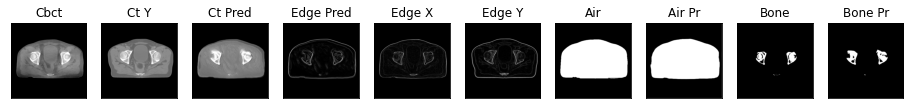

72it [00:36,  1.96it/s]

ssim score = 0.7915655970573425
psnr score = 21.788854598999023
snr score = 12.196745872497559
mae error = 0.03360249102115631
air dice score = 0.9766141416839349
bone dice score = 0.8452307311660865
contour dice score = 0.026867276057600975


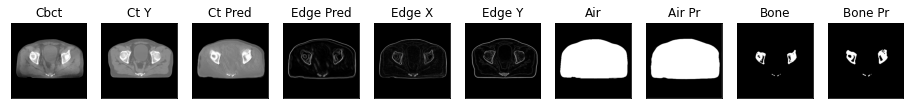

73it [00:36,  2.01it/s]

ssim score = 0.7901442646980286
psnr score = 21.72939109802246
snr score = 12.229456901550293
mae error = 0.033577218651771545
air dice score = 0.9768928547646194
bone dice score = 0.7901588128118958
contour dice score = 0.022875817492604256


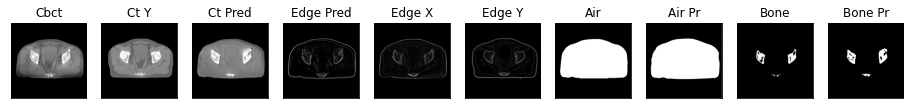

74it [00:37,  2.07it/s]

ssim score = 0.7889376878738403
psnr score = 21.854755401611328
snr score = 12.291393280029297
mae error = 0.033652354031801224
air dice score = 0.9766527606140973
bone dice score = 0.7975512528502626
contour dice score = 0.023379383608698845


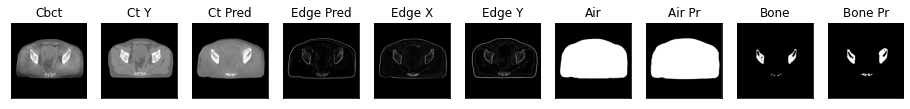

75it [00:37,  2.08it/s]

ssim score = 0.7964058518409729
psnr score = 22.12530517578125
snr score = 12.525548934936523
mae error = 0.032539039850234985
air dice score = 0.9765141536397043
bone dice score = 0.7789218655393864
contour dice score = 0.0274406336247921


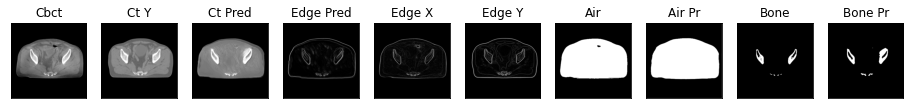

76it [00:38,  2.08it/s]

ssim score = 0.7918418049812317
psnr score = 22.029632568359375
snr score = 12.467623710632324
mae error = 0.03343416377902031
air dice score = 0.9764165796582837
bone dice score = 0.7570318021235756
contour dice score = 0.03781512752175331


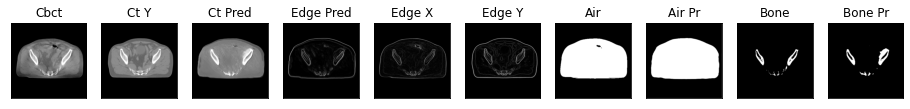

77it [00:38,  2.06it/s]

ssim score = 0.780895471572876
psnr score = 21.849634170532227
snr score = 12.41812801361084
mae error = 0.03488806262612343
air dice score = 0.9771778203946957
bone dice score = 0.7630947873310224
contour dice score = 0.04555084928870201


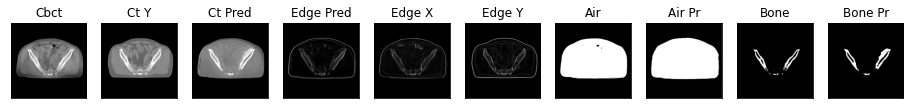

78it [00:39,  1.82it/s]

ssim score = 0.7858946323394775
psnr score = 21.948678970336914
snr score = 12.534921646118164
mae error = 0.03504116088151932
air dice score = 0.9770197307025922
bone dice score = 0.7250723493853581
contour dice score = 0.03940362110733986


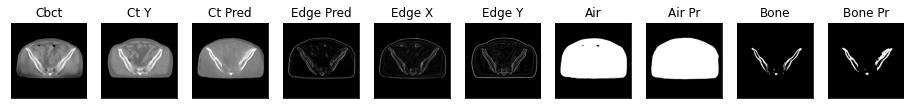

79it [00:40,  1.94it/s]

ssim score = 0.7863599061965942
psnr score = 22.316791534423828
snr score = 12.891767501831055
mae error = 0.03420286253094673
air dice score = 0.9768317477848534
bone dice score = 0.7101487778997058
contour dice score = 0.017094017937779427


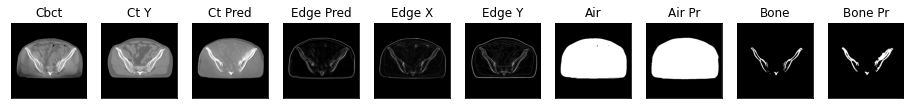

80it [00:40,  2.06it/s]

ssim score = 0.7843124866485596
psnr score = 22.37778663635254
snr score = 12.952020645141602
mae error = 0.0339355543255806
air dice score = 0.9776022187670903
bone dice score = 0.6895373291313153
contour dice score = 0.026983270421624184


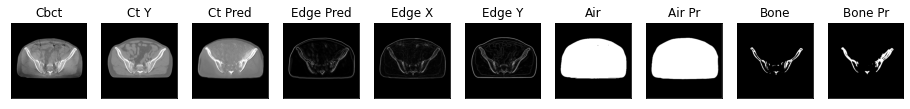

81it [00:40,  2.13it/s]

ssim score = 0.8005316257476807
psnr score = 22.996244430541992
snr score = 13.430377006530762
mae error = 0.030335208401083946
air dice score = 0.9750069812901618
bone dice score = 0.6516853932673216
contour dice score = 0.029613960534334183


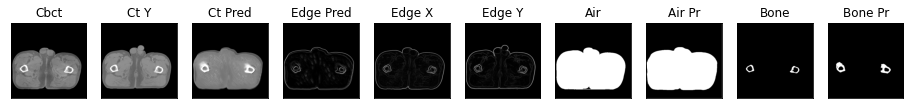

82it [00:41,  2.27it/s]

ssim score = 0.798902690410614
psnr score = 23.099342346191406
snr score = 13.597867965698242
mae error = 0.03037700429558754
air dice score = 0.9763941050813394
bone dice score = 0.6481178396154286
contour dice score = 0.03554626181721687


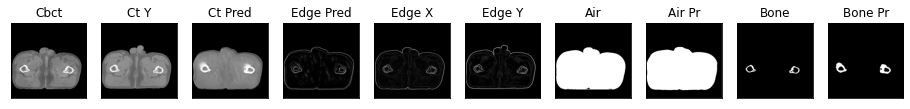

83it [00:41,  2.23it/s]

ssim score = 0.8115416765213013
psnr score = 24.39965057373047
snr score = 15.03738784790039
mae error = 0.028189249336719513
air dice score = 0.9766849260723128
bone dice score = 0.7636495556001515
contour dice score = 0.027522936463356018


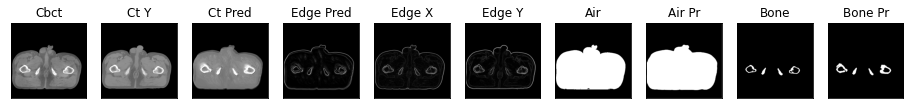

84it [00:42,  2.12it/s]

ssim score = 0.8100684285163879
psnr score = 24.118934631347656
snr score = 14.878164291381836
mae error = 0.029028479009866714
air dice score = 0.9766558831123642
bone dice score = 0.7324883255548285
contour dice score = 0.029774127528071404


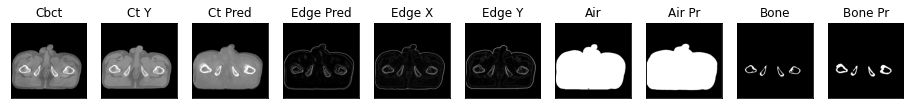

85it [00:42,  2.11it/s]

ssim score = 0.8039973378181458
psnr score = 23.817808151245117
snr score = 14.601211547851562
mae error = 0.029899664223194122
air dice score = 0.9774411004193473
bone dice score = 0.6927506775119792
contour dice score = 0.04439855366945267


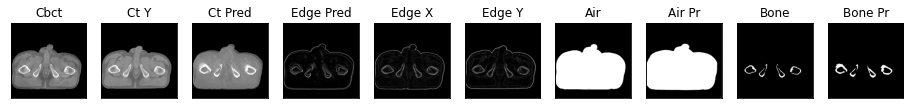

86it [00:43,  2.17it/s]

ssim score = 0.7972326874732971
psnr score = 23.619464874267578
snr score = 14.39847183227539
mae error = 0.030732834711670876
air dice score = 0.977375839790363
bone dice score = 0.6934528573764455
contour dice score = 0.029045643284916878


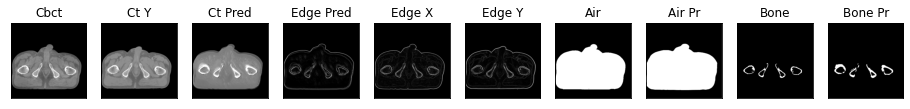

87it [00:43,  2.17it/s]

ssim score = 0.7992420196533203
psnr score = 23.403491973876953
snr score = 14.188753128051758
mae error = 0.03110997937619686
air dice score = 0.9783934945548133
bone dice score = 0.7092621664095877
contour dice score = 0.02400835044682026


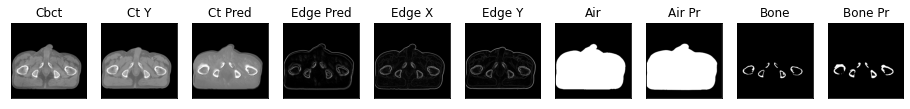

88it [00:44,  1.79it/s]

ssim score = 0.80046147108078
psnr score = 23.220367431640625
snr score = 13.984073638916016
mae error = 0.031239697709679604
air dice score = 0.9787853956114155
bone dice score = 0.7182748991666417
contour dice score = 0.04704652354121208


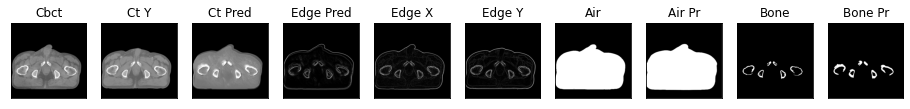

89it [00:44,  1.88it/s]

ssim score = 0.8073762059211731
psnr score = 23.512990951538086
snr score = 14.293604850769043
mae error = 0.030081314966082573
air dice score = 0.9794722300449986
bone dice score = 0.7390142517853472
contour dice score = 0.0589473694562912


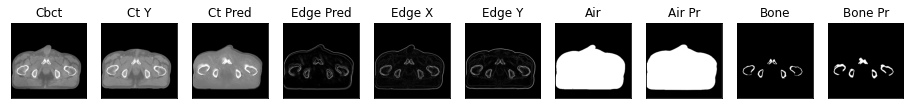

90it [00:45,  1.94it/s]

ssim score = 0.8122130036354065
psnr score = 23.878856658935547
snr score = 14.72806453704834
mae error = 0.029112543910741806
air dice score = 0.9800506189737194
bone dice score = 0.7472587719332887
contour dice score = 0.07712625712156296


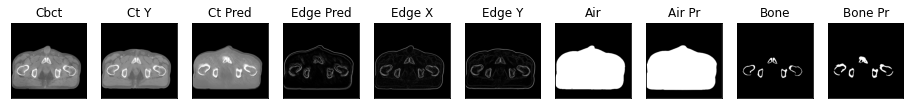

91it [00:45,  1.99it/s]

ssim score = 0.8126235008239746
psnr score = 24.145631790161133
snr score = 15.076199531555176
mae error = 0.02877432480454445
air dice score = 0.9808963206590379
bone dice score = 0.7607039663808681
contour dice score = 0.11246684193611145


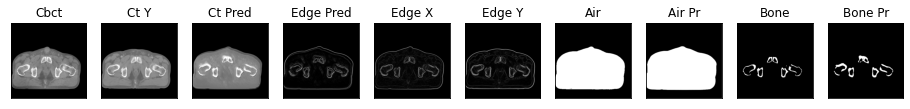

92it [00:46,  2.12it/s]

ssim score = 0.8138045072555542
psnr score = 24.3064022064209
snr score = 15.287673950195312
mae error = 0.028925981372594833
air dice score = 0.9807689339568916
bone dice score = 0.7178643724732051
contour dice score = 0.07557211071252823


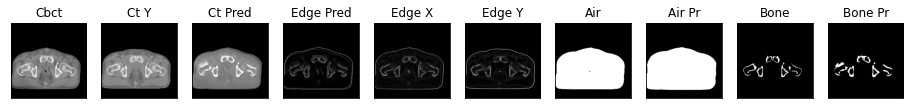

93it [00:46,  2.20it/s]

ssim score = 0.8109009861946106
psnr score = 24.38855743408203
snr score = 15.486096382141113
mae error = 0.02906958945095539
air dice score = 0.9804880313181948
bone dice score = 0.7173336699947312
contour dice score = 0.07565263658761978


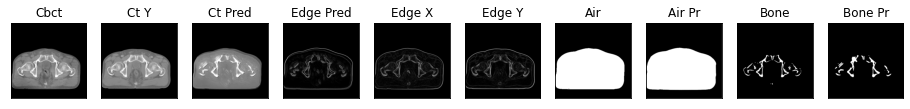

94it [00:47,  2.28it/s]

ssim score = 0.810226559638977
psnr score = 24.476850509643555
snr score = 15.536154747009277
mae error = 0.028782708570361137
air dice score = 0.9793730334460014
bone dice score = 0.6607848301335161
contour dice score = 0.07139051705598831


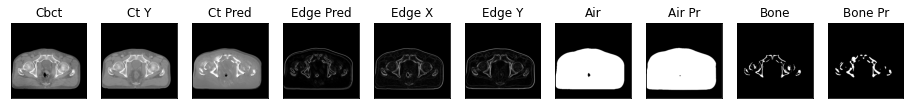

95it [00:47,  2.35it/s]

ssim score = 0.8116064071655273
psnr score = 23.867042541503906
snr score = 14.83067512512207
mae error = 0.030003389343619347
air dice score = 0.9788046412280799
bone dice score = 0.6837522992068209
contour dice score = 0.08004269003868103


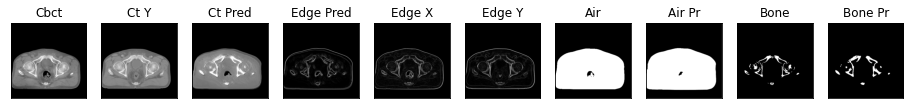

96it [00:47,  2.24it/s]

ssim score = 0.8142488598823547
psnr score = 23.928848266601562
snr score = 14.732721328735352
mae error = 0.02919948846101761
air dice score = 0.9770712560861641
bone dice score = 0.6739038488696757
contour dice score = 0.08658471703529358


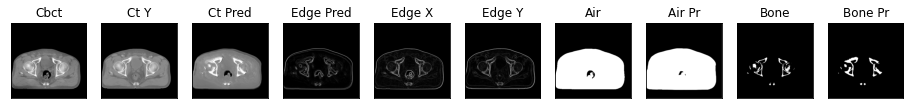

97it [00:48,  1.87it/s]

ssim score = 0.8172702789306641
psnr score = 23.644039154052734
snr score = 14.331488609313965
mae error = 0.029664523899555206
air dice score = 0.9765224645453648
bone dice score = 0.6870164580153746
contour dice score = 0.08807733654975891


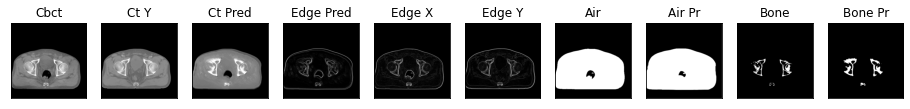

98it [00:49,  1.57it/s]

ssim score = 0.8181394338607788
psnr score = 23.607255935668945
snr score = 14.249611854553223
mae error = 0.029655421152710915
air dice score = 0.9754710500882791
bone dice score = 0.6777469990808898
contour dice score = 0.07965554296970367


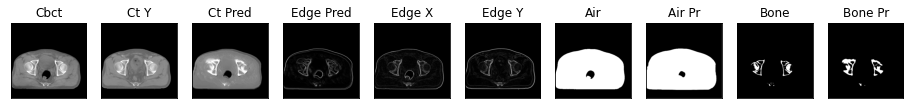

99it [00:49,  1.76it/s]

ssim score = 0.8158876895904541
psnr score = 23.209487915039062
snr score = 13.858516693115234
mae error = 0.03053213842213154
air dice score = 0.9763311714308781
bone dice score = 0.7274683884890036
contour dice score = 0.07978436350822449


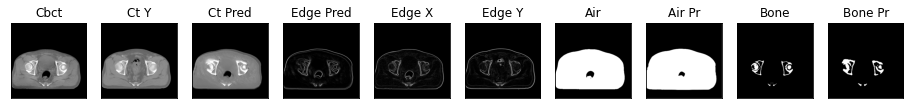

100it [00:50,  1.87it/s]

ssim score = 0.8181901574134827
psnr score = 23.057037353515625
snr score = 13.736169815063477
mae error = 0.030675427988171577
air dice score = 0.9770421268944444
bone dice score = 0.7857718120834124
contour dice score = 0.0788336917757988


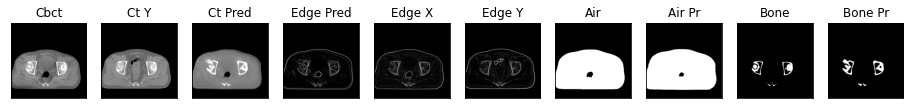

101it [00:50,  1.97it/s]

ssim score = 0.8239424824714661
psnr score = 23.396282196044922
snr score = 14.032829284667969
mae error = 0.029713021591305733
air dice score = 0.978111560433935
bone dice score = 0.7776828921181657
contour dice score = 0.07679826766252518


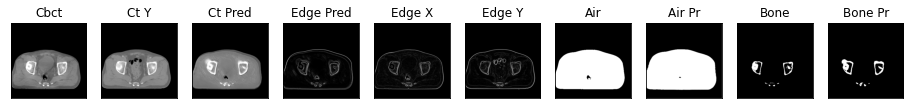

102it [00:51,  2.05it/s]

ssim score = 0.8221715688705444
psnr score = 23.43059730529785
snr score = 13.976940155029297
mae error = 0.029353966936469078
air dice score = 0.9794683554515917
bone dice score = 0.772684160610612
contour dice score = 0.08103727549314499


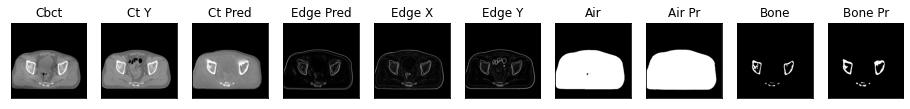

103it [00:51,  2.11it/s]

ssim score = 0.8183165192604065
psnr score = 23.060035705566406
snr score = 13.540650367736816
mae error = 0.030185947194695473
air dice score = 0.9773973605845301
bone dice score = 0.7793594306085513
contour dice score = 0.07575757801532745


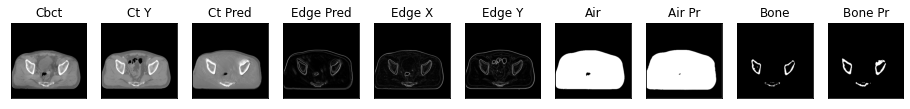

104it [00:52,  2.14it/s]

ssim score = 0.8144935965538025
psnr score = 22.924726486206055
snr score = 13.405038833618164
mae error = 0.030695024877786636
air dice score = 0.9774182178834785
bone dice score = 0.7868900646709746
contour dice score = 0.0781334787607193


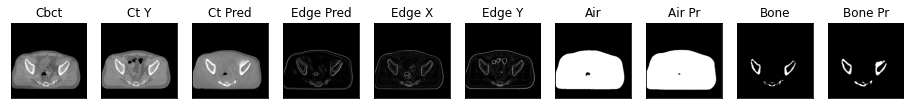

105it [00:52,  2.16it/s]

ssim score = 0.8090508580207825
psnr score = 22.860109329223633
snr score = 13.416589736938477
mae error = 0.030994385480880737
air dice score = 0.9757705974713033
bone dice score = 0.7758531540876958
contour dice score = 0.06535948067903519


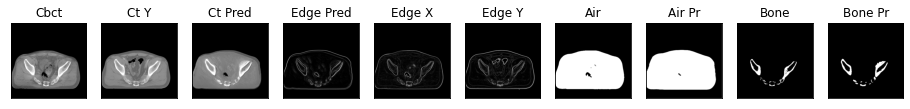

106it [00:53,  2.24it/s]

ssim score = 0.8113202452659607
psnr score = 22.767295837402344
snr score = 13.359356880187988
mae error = 0.03176049888134003
air dice score = 0.9758252362571743
bone dice score = 0.7704957678383252
contour dice score = 0.056830599904060364


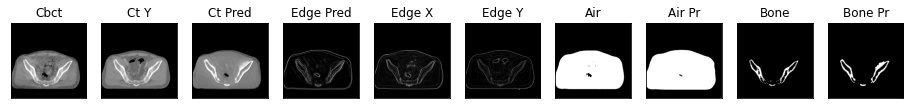

107it [00:53,  2.31it/s]

ssim score = 0.8121713399887085
psnr score = 22.81919288635254
snr score = 13.349555969238281
mae error = 0.032158125191926956
air dice score = 0.9759962517674623
bone dice score = 0.7368555060504538
contour dice score = 0.041643835604190826


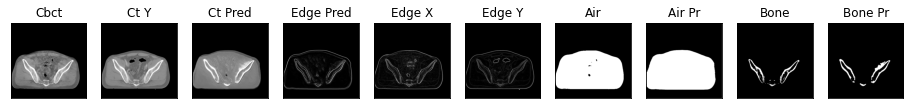

108it [00:54,  1.96it/s]

ssim score = 0.8102213740348816
psnr score = 22.704227447509766
snr score = 13.173328399658203
mae error = 0.03265227749943733
air dice score = 0.9757031091927095
bone dice score = 0.7303128371125902
contour dice score = 0.019933555275201797


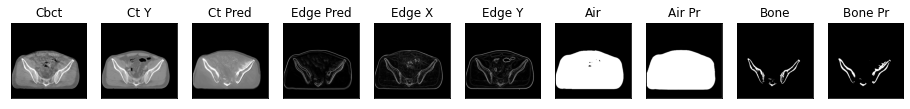

109it [00:54,  2.08it/s]

ssim score = 0.7729707360267639
psnr score = 21.794641494750977
snr score = 13.491947174072266
mae error = 0.038916051387786865
air dice score = 0.9896659878753893
bone dice score = 0.7716574862350611
contour dice score = 0.40810930728912354


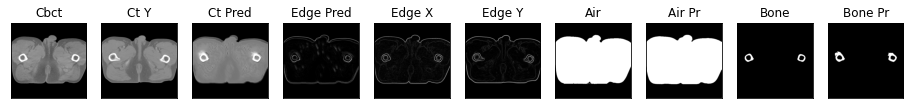

110it [00:54,  2.15it/s]

ssim score = 0.7651541829109192
psnr score = 21.5513916015625
snr score = 13.352989196777344
mae error = 0.04021787643432617
air dice score = 0.9903697234352312
bone dice score = 0.7930635838198136
contour dice score = 0.38263949751853943


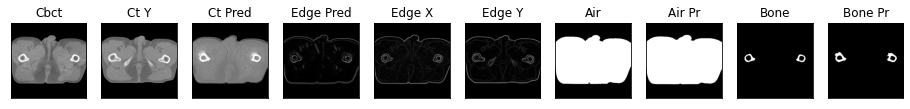

111it [00:55,  2.19it/s]

ssim score = 0.7579992413520813
psnr score = 21.34335708618164
snr score = 13.272911071777344
mae error = 0.041256777942180634
air dice score = 0.9908739419694226
bone dice score = 0.7720999627047351
contour dice score = 0.39928698539733887


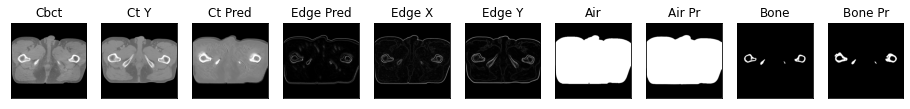

112it [00:55,  2.21it/s]

ssim score = 0.7578835487365723
psnr score = 21.099119186401367
snr score = 13.060962677001953
mae error = 0.04242529720067978
air dice score = 0.9913748660468669
bone dice score = 0.7967432393167092
contour dice score = 0.42806077003479004


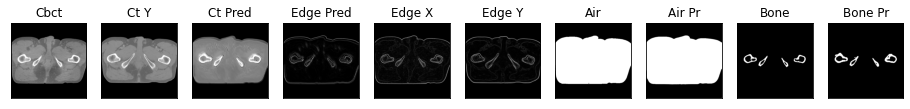

113it [00:56,  2.22it/s]

ssim score = 0.7495493292808533
psnr score = 20.918426513671875
snr score = 12.910508155822754
mae error = 0.04373297095298767
air dice score = 0.9915741051098651
bone dice score = 0.7706268323360236
contour dice score = 0.4202963709831238


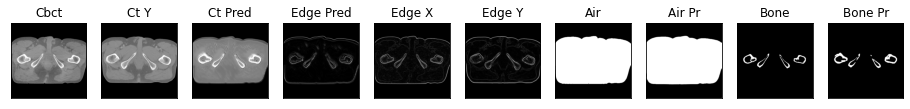

114it [00:56,  2.21it/s]

ssim score = 0.7449584007263184
psnr score = 20.871000289916992
snr score = 12.897499084472656
mae error = 0.044399987906217575
air dice score = 0.9914211802934939
bone dice score = 0.7806469149255144
contour dice score = 0.4263913929462433


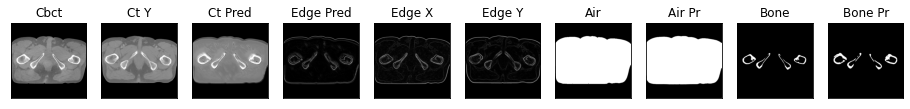

115it [00:57,  2.20it/s]

ssim score = 0.7403631210327148
psnr score = 20.654998779296875
snr score = 12.701807022094727
mae error = 0.045262087136507034
air dice score = 0.99201919985302
bone dice score = 0.7923504009896071
contour dice score = 0.4814317524433136


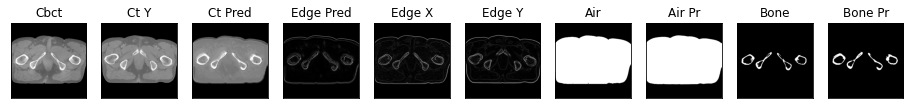

116it [00:57,  2.21it/s]

ssim score = 0.7388187646865845
psnr score = 20.627653121948242
snr score = 12.713533401489258
mae error = 0.04482380673289299
air dice score = 0.9926604662897552
bone dice score = 0.7808353808380732
contour dice score = 0.5503116846084595


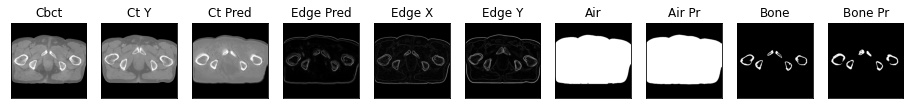

117it [00:58,  2.23it/s]

ssim score = 0.740561842918396
psnr score = 20.738418579101562
snr score = 12.872977256774902
mae error = 0.04378026723861694
air dice score = 0.9926360946066891
bone dice score = 0.7815979444539142
contour dice score = 0.5174643993377686


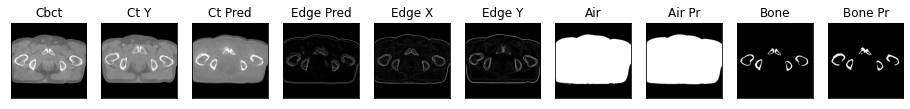

118it [00:58,  1.95it/s]

ssim score = 0.7342762351036072
psnr score = 20.647897720336914
snr score = 12.805069923400879
mae error = 0.04457562044262886
air dice score = 0.9918775615488281
bone dice score = 0.7867332382336336
contour dice score = 0.4837484061717987


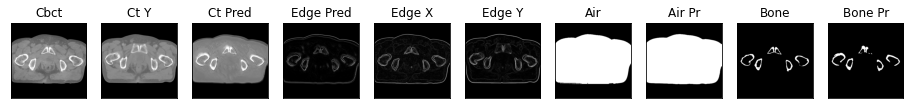

119it [00:59,  2.03it/s]

ssim score = 0.7233964800834656
psnr score = 20.5960750579834
snr score = 12.796026229858398
mae error = 0.04618619754910469
air dice score = 0.9917115220711518
bone dice score = 0.7816480667367641
contour dice score = 0.4978867173194885


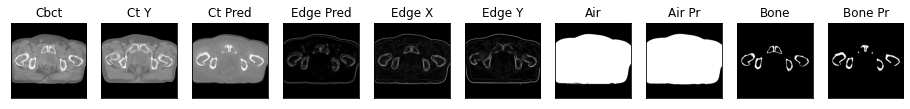

120it [00:59,  2.09it/s]

ssim score = 0.7188839912414551
psnr score = 20.405643463134766
snr score = 12.663930892944336
mae error = 0.04822211712598801
air dice score = 0.9926913253671482
bone dice score = 0.7717265353442354
contour dice score = 0.5479946136474609


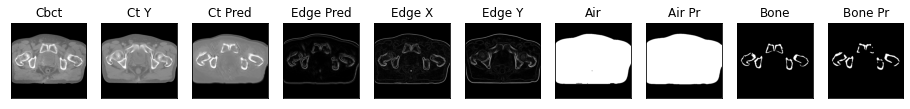

121it [01:00,  2.14it/s]

ssim score = 0.7130113840103149
psnr score = 20.151378631591797
snr score = 12.334297180175781
mae error = 0.05013151839375496
air dice score = 0.9927137038197552
bone dice score = 0.7490674463176825
contour dice score = 0.5117753744125366


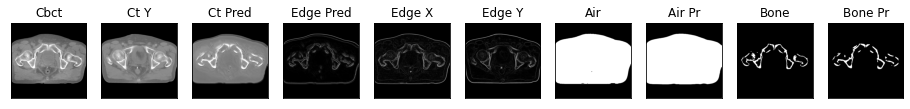

122it [01:00,  2.24it/s]

ssim score = 0.7205607891082764
psnr score = 19.96390151977539
snr score = 12.039600372314453
mae error = 0.05101852864027023
air dice score = 0.9929084477759907
bone dice score = 0.723620129872934
contour dice score = 0.5072463750839233


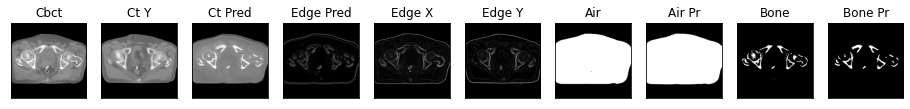

123it [01:00,  2.28it/s]

ssim score = 0.7234185338020325
psnr score = 20.052326202392578
snr score = 12.004937171936035
mae error = 0.05179233103990555
air dice score = 0.9924695446953372
bone dice score = 0.6519950637633484
contour dice score = 0.45748066902160645


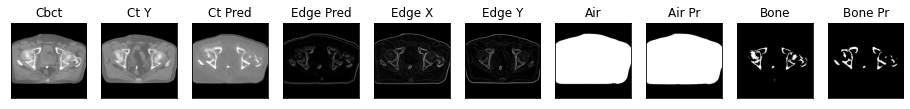

124it [01:01,  2.28it/s]

ssim score = 0.7276277542114258
psnr score = 20.21000099182129
snr score = 12.050182342529297
mae error = 0.05170378461480141
air dice score = 0.9918030445834451
bone dice score = 0.6969910435775687
contour dice score = 0.4240766167640686


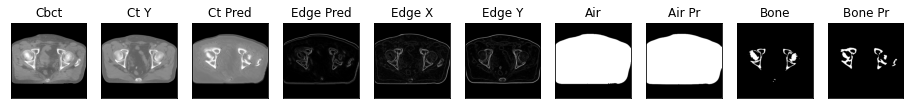

125it [01:01,  2.27it/s]

ssim score = 0.7319399118423462
psnr score = 20.36097526550293
snr score = 12.150510787963867
mae error = 0.05082693696022034
air dice score = 0.9913198818221427
bone dice score = 0.7209680699641959
contour dice score = 0.3963302671909332


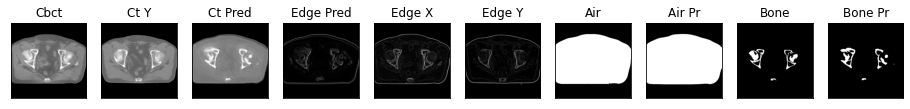

126it [01:02,  2.27it/s]

ssim score = 0.7318485975265503
psnr score = 20.22826385498047
snr score = 12.049952507019043
mae error = 0.051382988691329956
air dice score = 0.9909259025281176
bone dice score = 0.7248477210698923
contour dice score = 0.3744250237941742


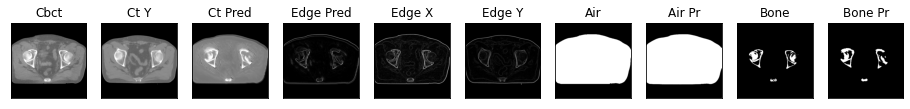

127it [01:02,  2.33it/s]

ssim score = 0.7289807200431824
psnr score = 19.96489143371582
snr score = 11.800056457519531
mae error = 0.05224219709634781
air dice score = 0.9903996865203817
bone dice score = 0.7408505301591511
contour dice score = 0.3594256639480591


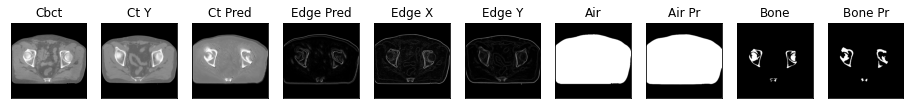

128it [01:03,  1.99it/s]

ssim score = 0.7264837622642517
psnr score = 19.870956420898438
snr score = 11.564630508422852
mae error = 0.05265756696462631
air dice score = 0.9897213894644301
bone dice score = 0.7954154727817143
contour dice score = 0.34034767746925354


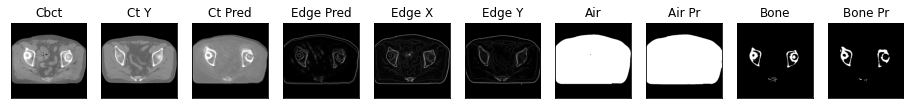

129it [01:03,  2.05it/s]

ssim score = 0.7334851622581482
psnr score = 19.837215423583984
snr score = 11.47158145904541
mae error = 0.05248922482132912
air dice score = 0.9896403497036421
bone dice score = 0.8056352075825254
contour dice score = 0.35680750012397766


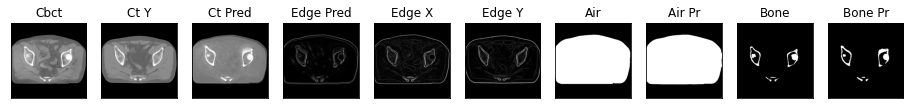

130it [01:04,  2.11it/s]

ssim score = 0.7391060590744019
psnr score = 20.107616424560547
snr score = 11.767630577087402
mae error = 0.049222517758607864
air dice score = 0.9901681532387834
bone dice score = 0.7297215496408941
contour dice score = 0.3550962805747986


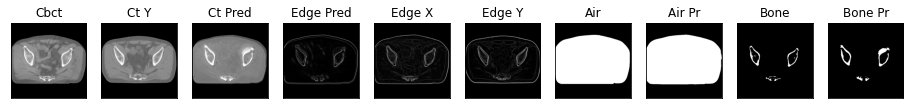

131it [01:04,  2.15it/s]

ssim score = 0.7378288507461548
psnr score = 20.249893188476562
snr score = 11.982721328735352
mae error = 0.04754766821861267
air dice score = 0.9899897134460015
bone dice score = 0.7718525047778485
contour dice score = 0.31969910860061646


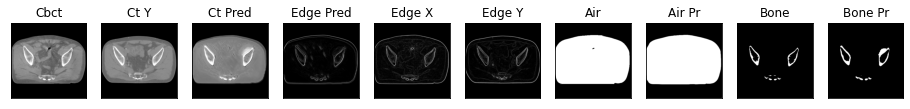

132it [01:05,  2.25it/s]

ssim score = 0.7281058430671692
psnr score = 20.03485870361328
snr score = 11.896916389465332
mae error = 0.04855473339557648
air dice score = 0.9897126640652775
bone dice score = 0.7700474993046934
contour dice score = 0.33744075894355774


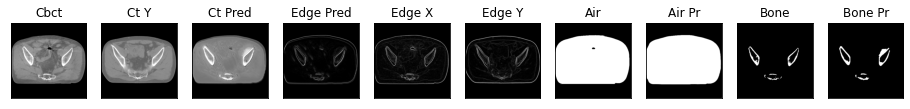

133it [01:05,  2.26it/s]

ssim score = 0.7169935703277588
psnr score = 19.794818878173828
snr score = 11.690836906433105
mae error = 0.050257083028554916
air dice score = 0.9892841223143507
bone dice score = 0.7706806282752529
contour dice score = 0.3441372811794281


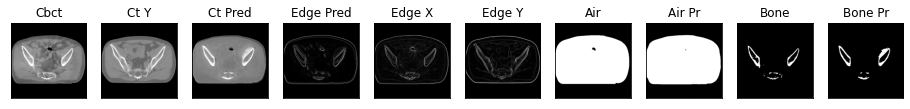

134it [01:05,  2.27it/s]

ssim score = 0.7176675200462341
psnr score = 19.97104835510254
snr score = 11.837274551391602
mae error = 0.04945501312613487
air dice score = 0.9899270621492573
bone dice score = 0.743942218083132
contour dice score = 0.34241989254951477


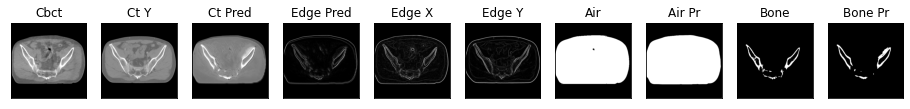

135it [01:06,  2.25it/s]

ssim score = 0.7132923603057861
psnr score = 19.981773376464844
snr score = 11.784625053405762
mae error = 0.04942827299237251
air dice score = 0.9899913801360083
bone dice score = 0.7337662337695584
contour dice score = 0.333812952041626


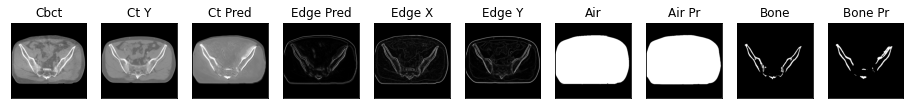

136it [01:06,  2.25it/s]

ssim score = 0.7853929996490479
psnr score = 22.911136627197266
snr score = 14.388527870178223
mae error = 0.03332195430994034
air dice score = 0.9819897208916457
bone dice score = 0.7607058559091748
contour dice score = 0.07065750658512115


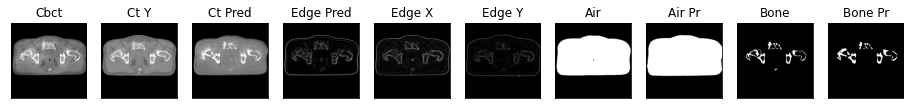

137it [01:07,  2.26it/s]

ssim score = 0.7859616875648499
psnr score = 23.325382232666016
snr score = 14.842782974243164
mae error = 0.032328519970178604
air dice score = 0.9815358822028782
bone dice score = 0.7510770703715763
contour dice score = 0.050073638558387756


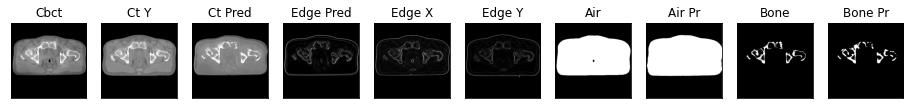

138it [01:07,  1.97it/s]

ssim score = 0.78616863489151
psnr score = 23.372573852539062
snr score = 14.897764205932617
mae error = 0.03191933035850525
air dice score = 0.9814067822573134
bone dice score = 0.6996457798986241
contour dice score = 0.05190989375114441


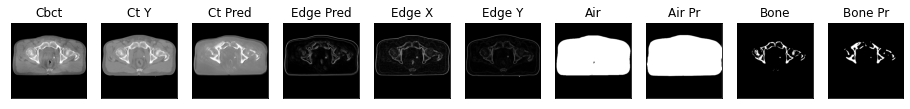

139it [01:08,  2.05it/s]

ssim score = 0.7897831201553345
psnr score = 23.547828674316406
snr score = 15.014599800109863
mae error = 0.031156420707702637
air dice score = 0.9803649229509779
bone dice score = 0.6972730410804593
contour dice score = 0.06292352080345154


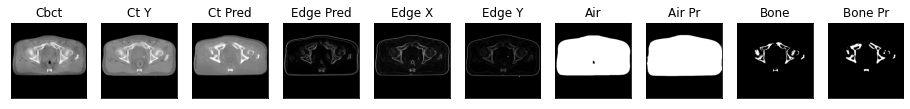

140it [01:08,  2.11it/s]

ssim score = 0.7954819798469543
psnr score = 23.710735321044922
snr score = 15.021881103515625
mae error = 0.02994733490049839
air dice score = 0.9791192131070852
bone dice score = 0.6939759036183389
contour dice score = 0.04393409937620163


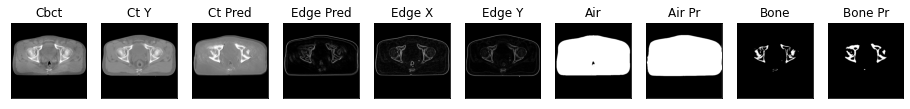

141it [01:09,  2.15it/s]

ssim score = 0.8011783957481384
psnr score = 23.957077026367188
snr score = 15.247416496276855
mae error = 0.029435522854328156
air dice score = 0.9797963471795849
bone dice score = 0.715600834666557
contour dice score = 0.053386058658361435


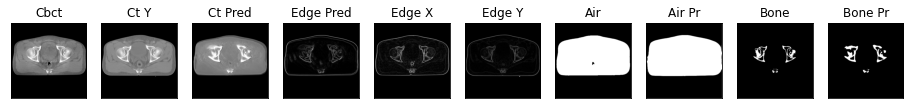

142it [01:09,  2.19it/s]

ssim score = 0.8029731512069702
psnr score = 23.868295669555664
snr score = 15.143009185791016
mae error = 0.029802557080984116
air dice score = 0.9804060382145082
bone dice score = 0.7154291343465653
contour dice score = 0.07296352088451385


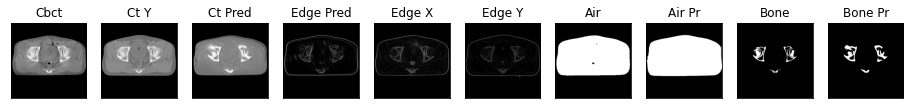

143it [01:10,  2.28it/s]

ssim score = 0.8058410882949829
psnr score = 23.511634826660156
snr score = 14.795711517333984
mae error = 0.030292000621557236
air dice score = 0.9793732058832386
bone dice score = 0.717726991973839
contour dice score = 0.043194375932216644


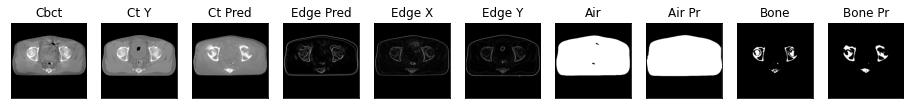

144it [01:10,  2.30it/s]

ssim score = 0.8045076131820679
psnr score = 23.469707489013672
snr score = 14.809566497802734
mae error = 0.030360089614987373
air dice score = 0.9801572000593355
bone dice score = 0.7583867320045434
contour dice score = 0.04038364440202713


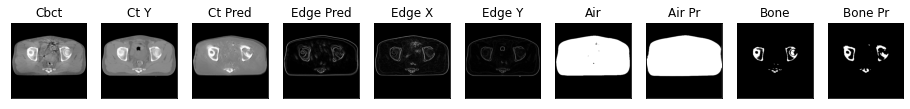

145it [01:10,  2.25it/s]

ssim score = 0.8053869605064392
psnr score = 22.97857666015625
snr score = 14.296504020690918
mae error = 0.031415365636348724
air dice score = 0.9793624086124129
bone dice score = 0.7882023221701828
contour dice score = 0.03453529626131058


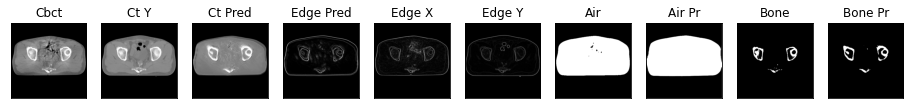

146it [01:11,  2.24it/s]

ssim score = 0.8094950914382935
psnr score = 22.769792556762695
snr score = 14.016944885253906
mae error = 0.03130289167165756
air dice score = 0.9784906110995175
bone dice score = 0.7691210045695045
contour dice score = 0.02852776274085045


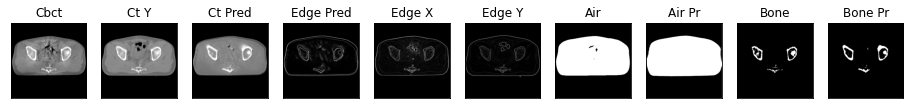

147it [01:11,  2.21it/s]

ssim score = 0.8096188306808472
psnr score = 22.941028594970703
snr score = 14.144290924072266
mae error = 0.030941495671868324
air dice score = 0.9790391642567466
bone dice score = 0.7610695802219513
contour dice score = 0.03006739169359207


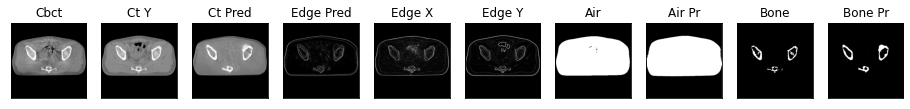

148it [01:12,  1.89it/s]

ssim score = 0.8167364597320557
psnr score = 23.458702087402344
snr score = 14.660868644714355
mae error = 0.029675837606191635
air dice score = 0.9783737996896784
bone dice score = 0.7777618979594432
contour dice score = 0.024960998445749283


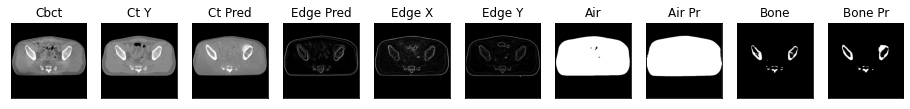

149it [01:12,  2.03it/s]

ssim score = 0.8113124966621399
psnr score = 23.543901443481445
snr score = 14.759422302246094
mae error = 0.03024553321301937
air dice score = 0.9778928200575043
bone dice score = 0.7721164613693713
contour dice score = 0.03232533857226372


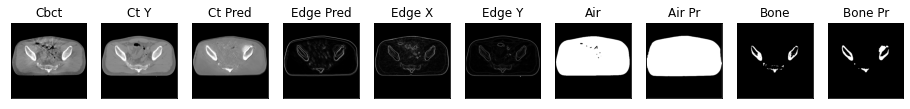

150it [01:13,  2.12it/s]

ssim score = 0.8043028712272644
psnr score = 23.386127471923828
snr score = 14.656853675842285
mae error = 0.030993061140179634
air dice score = 0.977197024056817
bone dice score = 0.765159867698577
contour dice score = 0.052273914217948914


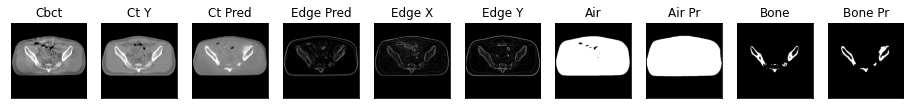

151it [01:13,  2.15it/s]

ssim score = 0.8037216067314148
psnr score = 22.91917610168457
snr score = 14.209271430969238
mae error = 0.032123833894729614
air dice score = 0.977786187322628
bone dice score = 0.7709980237182436
contour dice score = 0.06816989928483963


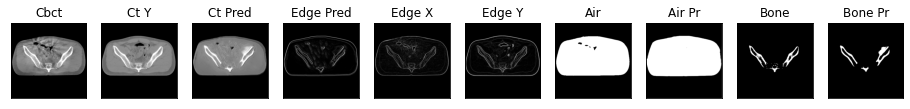

152it [01:14,  2.17it/s]

ssim score = 0.8013895750045776
psnr score = 22.474287033081055
snr score = 13.709644317626953
mae error = 0.033021677285432816
air dice score = 0.9797718078094612
bone dice score = 0.7379336832705424
contour dice score = 0.08832807838916779


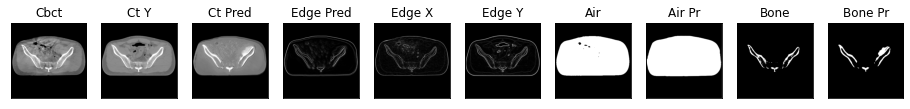

153it [01:14,  2.18it/s]

ssim score = 0.7955023050308228
psnr score = 22.156200408935547
snr score = 13.355205535888672
mae error = 0.03441930562257767
air dice score = 0.980909490667045
bone dice score = 0.6945503752036591
contour dice score = 0.1119324192404747


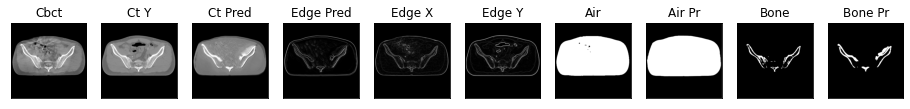

154it [01:15,  2.19it/s]

ssim score = 0.7945640683174133
psnr score = 22.16982650756836
snr score = 13.368903160095215
mae error = 0.03431468829512596
air dice score = 0.9810212552834814
bone dice score = 0.7067894131219011
contour dice score = 0.09750927239656448


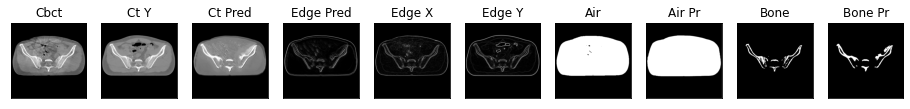

155it [01:15,  2.20it/s]

ssim score = 0.7952756285667419
psnr score = 22.6571102142334
snr score = 13.854764938354492
mae error = 0.03320794180035591
air dice score = 0.9810615272373685
bone dice score = 0.6986184130126101
contour dice score = 0.08208955079317093


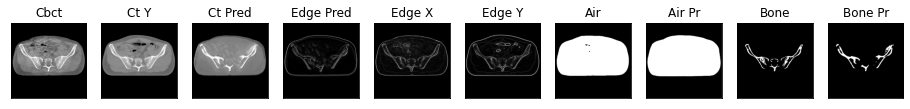

156it [01:16,  2.20it/s]

ssim score = 0.790044367313385
psnr score = 22.543231964111328
snr score = 13.74592399597168
mae error = 0.033329159021377563
air dice score = 0.9807085714285861
bone dice score = 0.7113186678172383
contour dice score = 0.07618025690317154


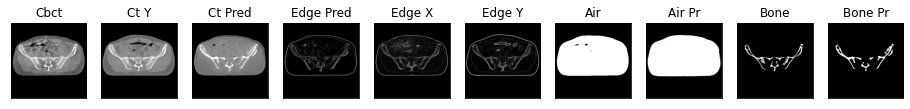

157it [01:16,  2.22it/s]

ssim score = 0.7897577881813049
psnr score = 22.18980598449707
snr score = 13.375226974487305
mae error = 0.03420281410217285
air dice score = 0.9799724602203336
bone dice score = 0.7306509482351274
contour dice score = 0.07879114896059036


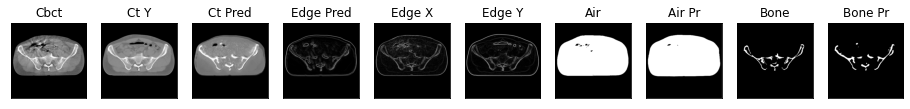

158it [01:17,  1.91it/s]

ssim score = 0.789272129535675
psnr score = 21.96649169921875
snr score = 13.13328742980957
mae error = 0.03482192009687424
air dice score = 0.9796341360436798
bone dice score = 0.7300124533034867
contour dice score = 0.09021738916635513


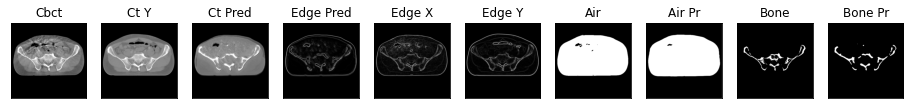

159it [01:17,  1.99it/s]

ssim score = 0.7835016250610352
psnr score = 21.709339141845703
snr score = 12.830199241638184
mae error = 0.0358547605574131
air dice score = 0.9790064435668422
bone dice score = 0.7050272562119317
contour dice score = 0.06670311838388443


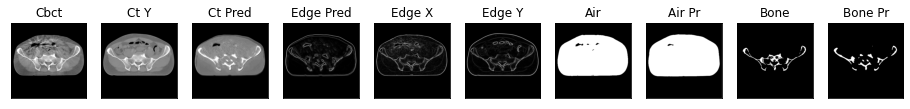

160it [01:18,  2.08it/s]

ssim score = 0.7827906608581543
psnr score = 22.004432678222656
snr score = 13.071494102478027
mae error = 0.034774299710989
air dice score = 0.9782222565449238
bone dice score = 0.7608618021692553
contour dice score = 0.07150714844465256


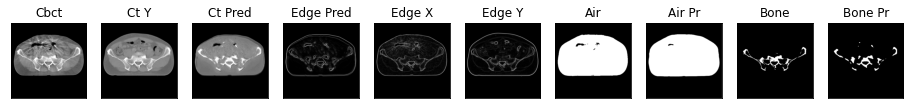

161it [01:18,  2.12it/s]

ssim score = 0.7780539393424988
psnr score = 21.800888061523438
snr score = 12.898411750793457
mae error = 0.03572181984782219
air dice score = 0.978396953078354
bone dice score = 0.78749552559614
contour dice score = 0.072727270424366


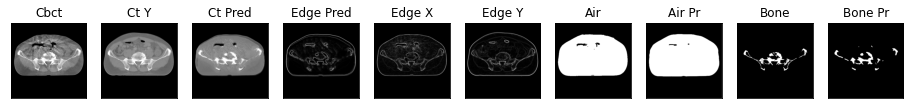

162it [01:19,  2.14it/s]

ssim score = 0.7729010581970215
psnr score = 21.435222625732422
snr score = 12.477521896362305
mae error = 0.03648856282234192
air dice score = 0.9784974657172343
bone dice score = 0.7929472266463456
contour dice score = 0.10352423042058945


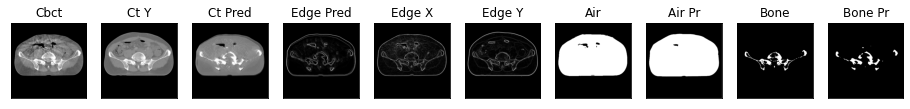

163it [01:19,  2.17it/s]

ssim score = 0.7834964990615845
psnr score = 22.106292724609375
snr score = 13.001059532165527
mae error = 0.03428053483366966
air dice score = 0.9794138035782599
bone dice score = 0.8060112711358045
contour dice score = 0.09955751895904541


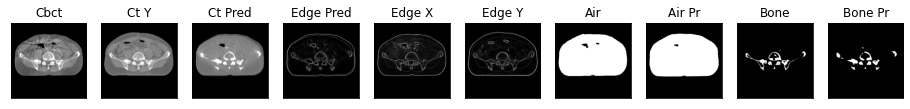

164it [01:19,  2.20it/s]

ssim score = 0.8004387617111206
psnr score = 23.190832138061523
snr score = 13.571743965148926
mae error = 0.035261306911706924
air dice score = 0.9823861171366721
bone dice score = 0.7064201947981232
contour dice score = 0.18452666699886322


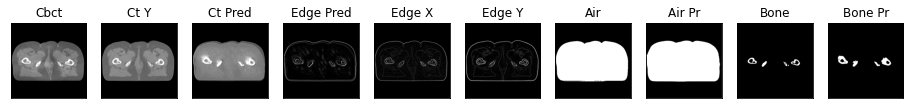

165it [01:20,  2.23it/s]

ssim score = 0.8010356426239014
psnr score = 23.20203399658203
snr score = 13.703958511352539
mae error = 0.03543362393975258
air dice score = 0.983697567219681
bone dice score = 0.711391111872784
contour dice score = 0.19481155276298523


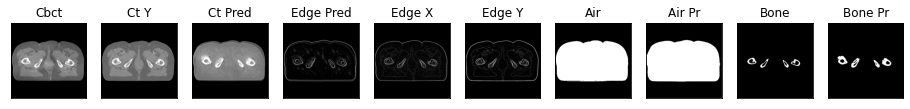

166it [01:20,  2.30it/s]

ssim score = 0.7998181581497192
psnr score = 23.20417022705078
snr score = 13.789010047912598
mae error = 0.035610269755125046
air dice score = 0.9836163964646402
bone dice score = 0.7125592779606462
contour dice score = 0.20803096890449524


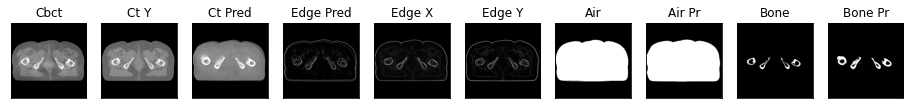

167it [01:21,  2.31it/s]

ssim score = 0.7970782518386841
psnr score = 23.22928237915039
snr score = 13.877567291259766
mae error = 0.03569284826517105
air dice score = 0.9848627249943147
bone dice score = 0.7397737162787964
contour dice score = 0.21985472738742828


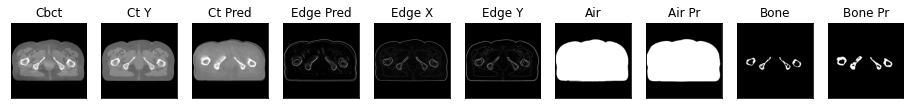

168it [01:21,  1.95it/s]

ssim score = 0.7994509339332581
psnr score = 23.298559188842773
snr score = 13.97530746459961
mae error = 0.03562488406896591
air dice score = 0.9851032270427279
bone dice score = 0.7960565038287808
contour dice score = 0.23133236169815063


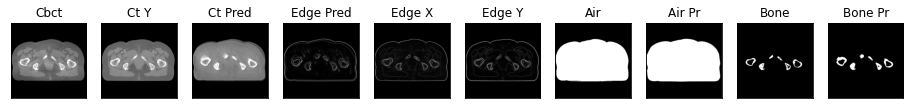

169it [01:22,  2.10it/s]

ssim score = 0.8002657890319824
psnr score = 23.267311096191406
snr score = 13.967013359069824
mae error = 0.03569972515106201
air dice score = 0.9839303767488996
bone dice score = 0.7828597477619987
contour dice score = 0.19401544332504272


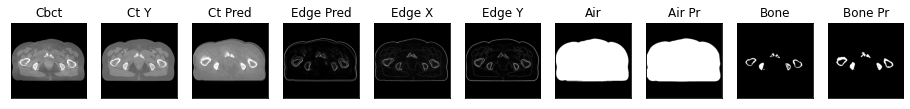

170it [01:22,  2.18it/s]

ssim score = 0.797581672668457
psnr score = 23.21324348449707
snr score = 13.9442720413208
mae error = 0.035709697753190994
air dice score = 0.9841341507291066
bone dice score = 0.7671472258662131
contour dice score = 0.19722355902194977


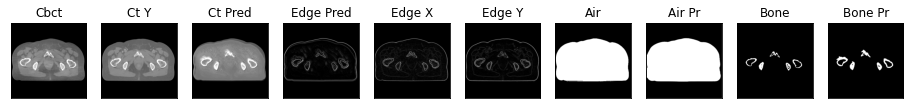

171it [01:23,  2.19it/s]

ssim score = 0.7975745797157288
psnr score = 23.16972541809082
snr score = 13.949118614196777
mae error = 0.03576750308275223
air dice score = 0.9848470959872058
bone dice score = 0.7539046011009722
contour dice score = 0.21145784854888916


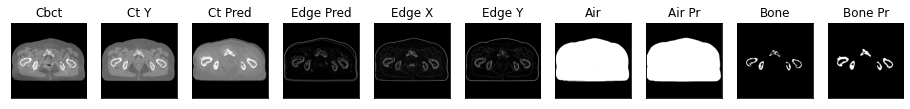

172it [01:23,  2.21it/s]

ssim score = 0.7973085641860962
psnr score = 23.219566345214844
snr score = 14.041702270507812
mae error = 0.03580212593078613
air dice score = 0.9844567624367166
bone dice score = 0.7645935624691136
contour dice score = 0.21343496441841125


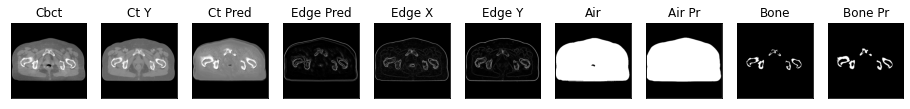

173it [01:24,  2.21it/s]

ssim score = 0.7957385182380676
psnr score = 23.402435302734375
snr score = 14.312275886535645
mae error = 0.03554568812251091
air dice score = 0.9842335354675051
bone dice score = 0.7748939356154867
contour dice score = 0.20945319533348083


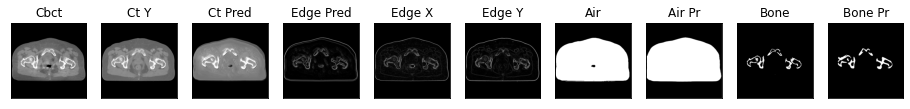

174it [01:24,  2.22it/s]

ssim score = 0.8032866716384888
psnr score = 23.799869537353516
snr score = 14.822983741760254
mae error = 0.034158628433942795
air dice score = 0.9849964176840081
bone dice score = 0.8004429678870382
contour dice score = 0.2015574872493744


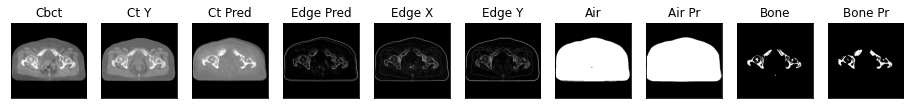

175it [01:24,  2.23it/s]

ssim score = 0.8055781722068787
psnr score = 23.5750675201416
snr score = 14.46962833404541
mae error = 0.03443275764584541
air dice score = 0.9824642686659489
bone dice score = 0.7119064005545505
contour dice score = 0.18532110750675201


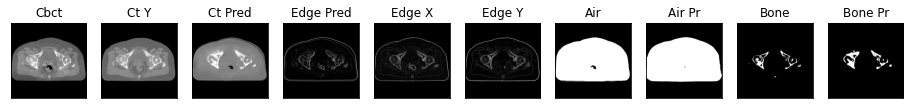

176it [01:25,  2.31it/s]

ssim score = 0.8030007481575012
psnr score = 23.340938568115234
snr score = 14.126075744628906
mae error = 0.035098180174827576
air dice score = 0.9820540692170258
bone dice score = 0.678322714480985
contour dice score = 0.16774193942546844


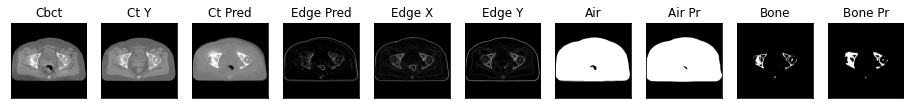

177it [01:25,  2.30it/s]

ssim score = 0.8002066612243652
psnr score = 23.20067596435547
snr score = 13.958688735961914
mae error = 0.03617718815803528
air dice score = 0.9821688297158325
bone dice score = 0.7274466921852454
contour dice score = 0.18304778635501862


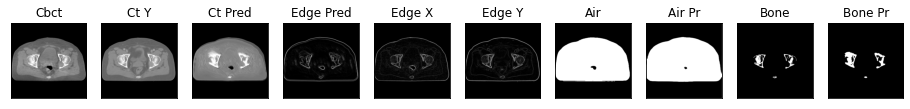

178it [01:26,  1.95it/s]

ssim score = 0.8068802356719971
psnr score = 23.71394920349121
snr score = 14.463957786560059
mae error = 0.035720840096473694
air dice score = 0.9835268963506602
bone dice score = 0.7558481580087428
contour dice score = 0.20984813570976257


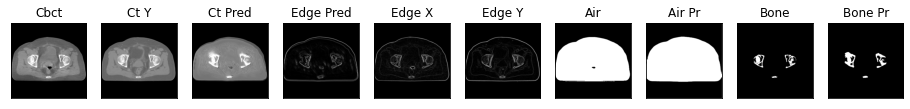

179it [01:26,  2.01it/s]

ssim score = 0.804804801940918
psnr score = 23.888202667236328
snr score = 14.67243766784668
mae error = 0.03551527485251427
air dice score = 0.985063516242661
bone dice score = 0.7950191570909275
contour dice score = 0.22634507715702057


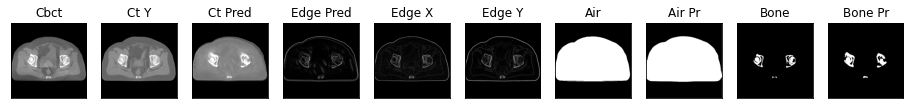

180it [01:27,  2.08it/s]

ssim score = 0.8097432851791382
psnr score = 23.636751174926758
snr score = 14.472480773925781
mae error = 0.03609229251742363
air dice score = 0.9853441489543859
bone dice score = 0.8277754906020616
contour dice score = 0.21990521252155304


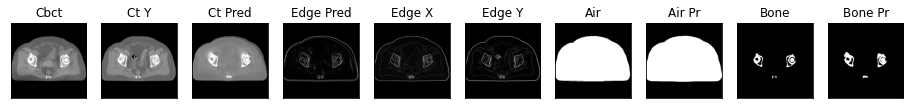

181it [01:27,  2.18it/s]

ssim score = 0.8031502962112427
psnr score = 23.140960693359375
snr score = 14.01424789428711
mae error = 0.03665860742330551
air dice score = 0.9855218123540056
bone dice score = 0.8071005917188299
contour dice score = 0.1958174854516983


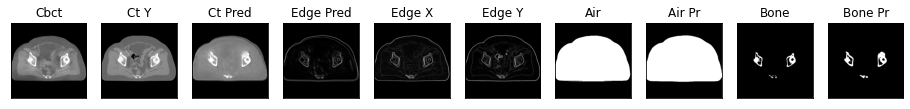

182it [01:28,  2.23it/s]

ssim score = 0.7913868427276611
psnr score = 21.960308074951172
snr score = 12.761157989501953
mae error = 0.04052695631980896
air dice score = 0.985536535909416
bone dice score = 0.7445102823327899
contour dice score = 0.20307987928390503


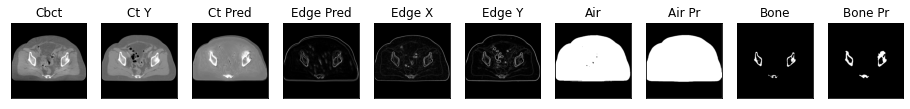

183it [01:28,  2.26it/s]

ssim score = 0.7851417064666748
psnr score = 21.8184871673584
snr score = 12.601346015930176
mae error = 0.04174664244055748
air dice score = 0.9839572908025476
bone dice score = 0.7512619669320929
contour dice score = 0.21108949184417725


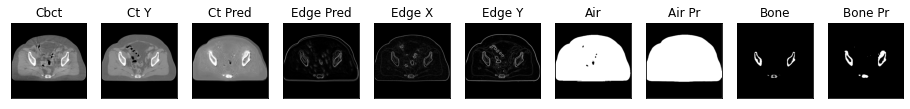

184it [01:29,  2.26it/s]

ssim score = 0.7883735299110413
psnr score = 22.261503219604492
snr score = 13.109272956848145
mae error = 0.0407877154648304
air dice score = 0.9853956047598625
bone dice score = 0.7467285075410514
contour dice score = 0.21529468894004822


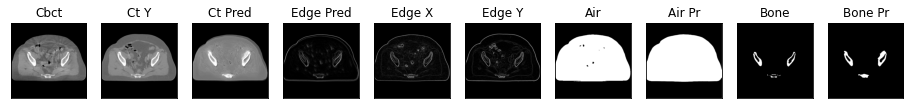

185it [01:29,  2.27it/s]

ssim score = 0.7864349484443665
psnr score = 22.19178009033203
snr score = 13.094645500183105
mae error = 0.041660912334918976
air dice score = 0.9860713980530286
bone dice score = 0.7772569181948094
contour dice score = 0.20845624804496765


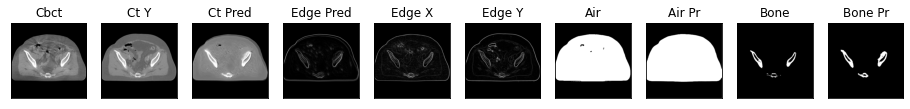

186it [01:29,  2.34it/s]

ssim score = 0.7792597413063049
psnr score = 21.730955123901367
snr score = 12.698248863220215
mae error = 0.043252721428871155
air dice score = 0.9871287709442679
bone dice score = 0.8118655240631264
contour dice score = 0.23603691160678864


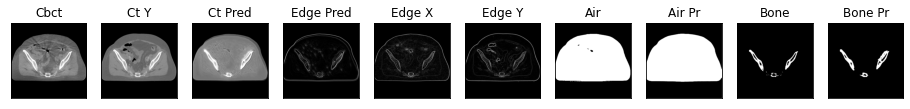

187it [01:30,  2.36it/s]

ssim score = 0.775922417640686
psnr score = 21.700117111206055
snr score = 12.740269660949707
mae error = 0.04370489344000816
air dice score = 0.9876648619978217
bone dice score = 0.7790555419650226
contour dice score = 0.24280838668346405


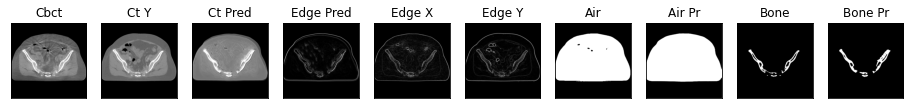

188it [01:31,  1.96it/s]

ssim score = 0.7707076668739319
psnr score = 21.7130184173584
snr score = 12.748882293701172
mae error = 0.04448850452899933
air dice score = 0.9876573305449072
bone dice score = 0.7552588487245843
contour dice score = 0.26737451553344727


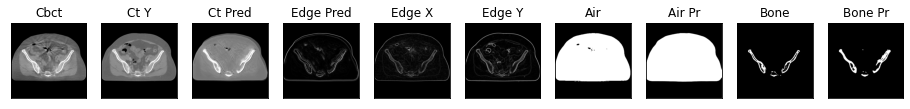

189it [01:31,  2.04it/s]

ssim score = 0.7712110280990601
psnr score = 21.57624053955078
snr score = 12.589927673339844
mae error = 0.04540444165468216
air dice score = 0.988586915031689
bone dice score = 0.760725453411373
contour dice score = 0.27434054017066956


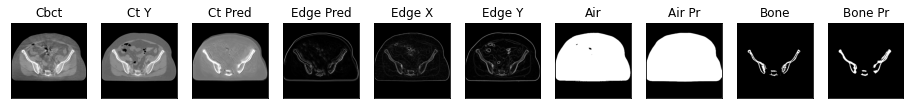

190it [01:31,  2.11it/s]

ssim score = 0.7724456787109375
psnr score = 21.85004425048828
snr score = 12.8753662109375
mae error = 0.04492054134607315
air dice score = 0.989083244989658
bone dice score = 0.7782699322592721
contour dice score = 0.30228137969970703


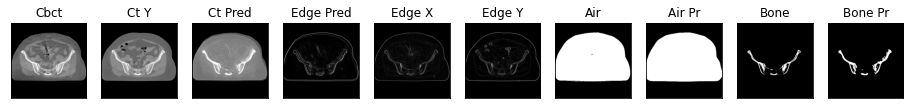

191it [01:32,  2.07it/s]


In [44]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [45]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [46]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [47]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:36,  5.23it/s]


(0.7900448297954978,
 22.295087754414343,
 13.299359741011216,
 0.03614230334992808,
 0.9795291330427941,
 0.7634270383472151,
 0.16647242395033077,
 0.7447643979057592,
 0.756544502617801)

In [48]:
# import torchvision.models as models
# models.vgg16(pretrained=True)